In [1]:
import os
import re
import pandas as pd
import dask.dataframe as dd
import numpy as np
import seaborn as sns

In [2]:
Analise_INDICE = True

In [3]:
mainpath = 'C:/Users/david/OneDrive/Documents/FERV_documentos/RESULTS'

dic_cenarios = {
                # 'MPA FNS Lim Scenario 2022' : f'{mainpath}/MPV_(FNS Lim)_RC/',
                # 'V1A1F2 2026' :f'{mainpath}/V1A1F2_RESP_FNS_lim_rev1_2026/',
                # 'V1A1F2 2026' :f'{mainpath}/V1A1F2_RESP_FNS_lim_rev2_2026/',
                # 'V1A1F3 2026' :f'{mainpath}/V1A1F3_RESP_FNS_lim_rev1_2026/',
                # 'V1A1F4 2026' :f'{mainpath}/V1A1F4_RESP_FNS_lim_rev1_2026/',
                # 'V1A1F5 2026' :f'{mainpath}/V1A1F5_RESP_FNS_lim_rev1_2026/',

                'V1A1F2' :f'{mainpath}/V1A1F2_rev5/',
                'V1A1F3' :f'{mainpath}/V1A1F3_rev5/',
                'V1A1F4' :f'{mainpath}/V1A1F4_rev5/',
                'V1A1F5' :f'{mainpath}/V1A1F5_rev5/',

                # 'V2A2F2' :f'{mainpath}/V2A2F2_rev5/', 
                # 'V2A2F3' :f'{mainpath}/V2A2F3_rev5/',
                # 'V2A2F4' :f'{mainpath}/V2A2F4_rev5/', 
                # 'V2A2F5' :f'{mainpath}/V2A2F5_rev5/',

                # 'V3A3F2' :f'{mainpath}/V3A3F2_rev5/',
                # 'V3A3F3' :f'{mainpath}/V3A3F3_rev5/',
                # 'V3A3F4' :f'{mainpath}/V3A3F4_rev5/', 
                # 'V3A3F5' :f'{mainpath}/V3A3F5_rev5/',
                }

dirGeral = 'StaticAnalysis/Data/Geral/'
# dirIndice = 'StaticAnalysis/Data/Indice_n_supremo/'
dirIndice = 'StaticAnalysis/Data/Indice_n_2/'
dirRamos = 'StaticAnalysis/Data/Fluxo em Ramos/'
dirPotencia = 'StaticAnalysis/Data/Potencia/'

filenames = [
                (dirGeral + 'OPF_NC.csv', 'OPF_NC'), 
                (dirGeral + 'PWF_NC.csv', 'PWF_NC'),
                (dirGeral + 'Df_ger.csv', 'ger'), 
                (dirGeral + 'Df_nt.csv', 'nt'), 
                (dirRamos + 'Df_Linhas.csv', 'linhas'), 
                (dirRamos + 'Df_Trafo.csv', 'Trafo'), 
                (dirRamos + 'DF_Intercambios.csv', 'intercambios'), 
                (dirRamos + 'DF_HVDC_bipoles.csv', 'HVDC'),
                (dirPotencia +'Df_Reserva_PO_MW.csv', 'pot_mw_reserv'),  
                # (dirIndice + 'Df_DPI_S2.csv', 'Index'), 
                (dirIndice +'Df_DPI_S4.csv', 'Index_PO'),  #deixar esse descomentado para poder filtrar os não convergidos
                # (dirIndice + 'Df_DPI_S3.csv', 'Index_Modif'), 
                # (dirIndice +'Df_PQ_DPI_S1.csv', 'IndexDec_PQ'), 
                # (dirIndice +'Df_PV_DPI_S1.csv', 'IndexDec_PV'), 
                (dirPotencia+'Df_MW-MVAR_PO.csv', 'pot_mw_mvar'), 
                (dirPotencia+'DF_POT_Reg.csv', 'ger_reg'),
                # (dirRamos+'Df_AreasInfo.csv', 'areas'),
            ]
import colorcet as cc
intense_palette = sns.color_palette(cc.glasbey, n_colors=12)  # You can adjust the number of colors as needed
namescenarios = {key:[key,intense_palette[idx]] for idx, key in enumerate(dic_cenarios.keys())}
itemsforanalysis = [var for _,var in filenames]

## Processamento de dados

In [4]:
# Optimized read_and_append function using Dask
def read_and_append(filename, cenario, lst):
    df = dd.read_csv(filename)  # Keep as Dask DataFrame for now
    df['Cenario'] = cenario
    # Avoid converting to pandas immediately; do this after processing
    lst.append(df)
    return lst

# Function to load and process all datasets
def load_and_process_data(dic_cenarios, filenames):
    keys = [i for _, i in filenames]
    dfs = {key: [] for key in keys}

    # Read and append data from each scenario and filename
    for cenario, path in dic_cenarios.items():
        for filename, key in filenames:
            dfs[key] = read_and_append(path + filename, cenario, dfs[key])

    # Convert all dask DataFrames to pandas after appending
    dfs = {key: dd.concat(lst).compute() for key, lst in dfs.items()}
    
    return dfs

# Function to calculate indices for lines
def IndiceLinhas(df, n):

    df['MW_Flow'] = np.where(df['MW:From-To'] >= 0, df['MW:From-To'], df['MW:To-From'])
    df['PI_mva'] = (df['% L1'] / 100) ** (2 * n)

    # Group by multiple columns and aggregate
    df_r_nt_1 = df[df['VBASEKV']>=500].groupby(
        ['key', 'Cenario', 'REG']
    ).agg({'MW_Flow': 'sum', 'MVA': 'sum', 'PI_mva': 'sum'})

    df_r_nt_2 = df[df['VBASEKV']<500].groupby(
        ['key', 'Cenario', 'REG']
    ).agg({'MW_Flow': 'sum', 'MVA': 'sum', 'PI_mva': 'sum'})

    df_r_nt_1['PI_mva_500up'] = df_r_nt_1['PI_mva'] ** (1 / (2 * n))
    df_r_nt_2['PI_mva_500down'] = df_r_nt_2['PI_mva'] ** (1 / (2 * n))

    df_r_nt = df_r_nt_1[['PI_mva_500up']].merge(df_r_nt_2[['PI_mva_500down']], on=['key', 'Cenario', 'REG'], how='outer')
    df_r_nt.fillna({'PI_mva_500up': 0, 'PI_mva_500down': 0,}, inplace=True)

    return df_r_nt

# Function to flatten DataFrame
def flatdf(df, BG):
    df_reordered = df.reorder_levels(['key','Dia', 'Hora', 'Cenario', 'REG', BG])
    regionmap = {
        'Nordeste': 'Northeast', 'Norte': 'North', 'Sudeste-Centro-Oeste': 'SE-CW',
        'Sul': 'South', 'AC-RO': 'AC-RO'
    }
    df_reordered = df_reordered.rename(index=regionmap, level='REG')
    df_reordered_sorted = df_reordered.sort_index(level=['key','Dia', 'Hora', 'Cenario', 'REG'])
    df_reordered_sorted.rename(columns={'CSI_INF': 'DPI_inf', 'CSI_SUP': 'DPI_sup'}, inplace=True)

    lista = [[index[0], index[1], index[2], index[3]] for index in df_reordered.index]
    conjunto_filtros = set(map(tuple, lista))
    conjunto_filtros = tuple(sorted(conjunto_filtros))

    data = [df_reordered_sorted.loc[i].values.flatten() for i in conjunto_filtros]
    datapd = pd.DataFrame(data, index=conjunto_filtros)
    datapd.index.names = ['key','Dia', 'Hora', 'Cenario']
    
    columns = []
    for reg in df_reordered_sorted.reset_index('REG')['REG'].unique():
        for bg in df_reordered_sorted.loc[:, :, :, : ,reg, :].reset_index(BG)[BG].unique():
            for column in df_reordered_sorted.columns:
                reg_name = 'SE-CO' if reg == 'Sudeste-Centro-Oeste' else reg
                columns.append(f"{column}_{reg_name}_{bg}")

    datapd.columns = columns
    return datapd

# Function to read data
def read_data():
    def read_and_append(filename, cenario, lst):
        df = dd.read_csv(filename)
        df['Cenario'] = cenario
        # if cenario == 'V1A1F2 Scenario 2022 FNS':
        #     df['Dia'] = df['Dia'] - 1
        lst.append(df.compute())
        return lst

    keys = [i for _,i in filenames]
    dfs = {}
    for key in keys:
        dfs[key] = []
    for i,j in  dic_cenarios.items():
        for filename, key in filenames:
            dfs[key] = read_and_append(j + filename, i, dfs[key])

    return dfs

# Function to filter data based on non-convergent conditions
def filtarNC(df, dfconv):
    mask_PWFCV = dfconv.reset_index()[['key', 'Cenario']]
    df_out = df.reset_index().merge(mask_PWFCV, on=['key', 'Cenario'], how='inner')
    
    return df_out

In [5]:
# Function to concatenate and process data (part 1)
def concatenation_1(data):
    

    data['df_ger_reg_concat'] = filtarNC(data['ger_reg'], data['Index_PO'])
   
    if all(keyword in itemsforanalysis for keyword in ['linhas', 'Trafo', 'intercambios', 'HVDC', 'pot_mw_reserv']):

        # print('====== Selecting Critical Lines as features ======')
        data['linhas']['L1(MVA)'] = data['linhas']['L1(MVA)'].astype('float32')
        data['linhas']['VBASEKV'] = data['linhas']['VBASEKV'].astype('int16')  # if appropriate for your data

        data['linhas'] = data['linhas'].loc[(data['linhas']['L1(MVA)'] != 9999) & (data['linhas']['VBASEKV'].isin([230, 345, 440, 500, 525, 765]))]
        # data['PI_mva'] = IndiceLinhas(data['linhas'], 1)  #para calcular o MWFLOW

        # data['features_lines'] = computefeatures_2(data['linhas'], data['PI_mva'].reset_index())
        data['Trafo'] = data['Trafo'].loc[(data['Trafo']['L1(MVA)'] != 9999) & (data['Trafo']['VBASEKV'].isin([230, 345, 440, 500, 525, 765]))]
        data['Trafo'] = data['Trafo'].rename(columns={'% L1': '% L1_Trafo', 'Mvar:Losses': 'Mvar:Losses_Trafo'})
        data['pot_mw_reserv'] = data['pot_mw_reserv'].set_index(['Dia', 'Hora', 'Cenario'])

        df_intercambios_01 = data['intercambios'].rename(columns={'Intercambio AC': 'Intercambio'}).set_index(['key','Dia', 'Hora', 'Cenario', 'Intercambio'])
        # df_hvdc_01 = data['HVDC'].rename(columns={'Nome Elo':'Intercambio', ' P(MW)': 'MW:From-To', ' Q(Mvar)': 'Mvar:From-To'}).set_index(['key','Dia', 'Hora', 'Cenario', 'Intercambio'])
        df_hvdc_01 = data['HVDC'].rename(columns={'Nome Elo':'Intercambio', ' P(MW)': 'MW:From-To'}).set_index(['key','Dia', 'Hora', 'Cenario', 'Intercambio', 'Bipole'])

        # concatenated_HVDC = pd.concat([
        #         df_hvdc_01.loc[:,:, :, :, 'Elo_FOZ-IBIUNA']['MW:From-To'],
        #         df_hvdc_01.loc[:,:, :, :, 'Elo_PVEL-ARARQ']['MW:From-To'],
        #         df_hvdc_01.loc[:,:, :, :, 'Elo_XINGU-SE']['MW:From-To'],
        #         # df_hvdc_01.loc[:,:, :, :, 'Elo_CPVBTB-PVEL']['MW:From-To']
        #         ], axis=1, keys=['Elo_FOZ-IBIUNA', 'Elo_PVEL-ARARQ', 'Elo_XINGU-SE'])
        
        concatenated_HVDC = pd.concat([
                df_hvdc_01.loc[:,:, :, :, 'Elo_FOZ-IBIUNA', 'Bipolo1']['MW:From-To'],
                df_hvdc_01.loc[:,:, :, :, 'Elo_FOZ-IBIUNA', 'Bipolo2']['MW:From-To'],
                df_hvdc_01.loc[:,:, :, :, 'Elo_PVEL-ARARQ', 'Bipolo1']['MW:From-To'],
                df_hvdc_01.loc[:,:, :, :, 'Elo_PVEL-ARARQ', 'Bipolo2']['MW:From-To'],
                df_hvdc_01.loc[:,:, :, :, 'Elo_XINGU-EST', 'Bipolo1']['MW:From-To'],
                df_hvdc_01.loc[:,:, :, :, 'Elo_XINGU-T_RIO', 'Bipolo2']['MW:From-To'],
                ], axis=1, keys=['Elo_FOZ-IBIUNA_BP1', 'Elo_FOZ-IBIUNA_BP2', 'Elo_PVEL-ARARQ_BP1','Elo_PVEL-ARARQ_BP2', 'Elo_XINGU-EST','Elo_XINGU-T_RIO'])

        concatenated_FluxoAC = pd.concat([
                df_intercambios_01.loc[:,:, :, :, 'EXP_NE']['MW:From-To'],
                df_intercambios_01.loc[:,:, :, :, 'Fluxo_NE-N']['MW:From-To'],
                df_intercambios_01.loc[:,:, :, :, 'Fluxo_NE-SE']['MW:From-To'], 
                df_intercambios_01.loc[:,:, :, :, 'Fluxo_N-S']['MW:From-To'],
                df_intercambios_01.loc[:,:, :, :, 'Fluxo_SUL-SECO']['MW:From-To']

                ], axis=1, keys=['EXP_NE', 'Fluxo_NE-N', 'Fluxo_NE-SE', 'Fluxo_N-S','Fluxo_SUL-SECO'])

        data['df_Inter_AC_DC'] = concatenated_HVDC.merge(concatenated_FluxoAC, on=['key','Dia', 'Hora', 'Cenario'], how='left')

    return data

# Function to concatenate and process data (part 2)
def concatenation_2(data):

    print('====== Second Concatenation ======')

    Jirau = [7051, 7061]
    S_Antonio = [7050, 7062, 7064]
    G_Uhe_230_ACRO = [6888, 6892, 6891]
    Tucurui = [6419, 6420, 6422, 6424, 6425]
    B_Monte = [6729]
    Itaipu_50 = [1100]
    Itaipu_60 = [1107]
    I_Solt = [501]
    AngraI = [10]
    AngraII = [11]
    TPires = [4492]
    S_Mesa = [36]
    XINGO = [5061]
    Furnas = [16]

    DF_complete_PO = data['df_ger_reg_concat'].drop(columns=['REG', 'PG_FERV']).groupby(by=['key','Dia', 'Hora', 'Cenario']).sum(numeric_only=True)
    DF_complete_PO['PG_FERV'] = (DF_complete_PO['PG_EOL'] + DF_complete_PO['PG_SOL']) / DF_complete_PO['PL_MW']
    DF_complete_PO['DL_MW'] = DF_complete_PO['PL_MW'] - (DF_complete_PO['PG_EOL'] + DF_complete_PO['PG_SOL'])
    
    if 'ger' in itemsforanalysis:
        Df_ger = data['ger']

        Df_ger = Df_ger[Df_ger['BUS_ID'].isin(Jirau + S_Antonio + Tucurui + B_Monte + Itaipu_50 + Itaipu_60 + I_Solt + G_Uhe_230_ACRO+AngraI+AngraII+TPires+S_Mesa+XINGO+Furnas)]
        DF_complete_PO[['Jirau_MW', 'Jirau_MVAR', 'Jirau_Reserva']] = Df_ger[Df_ger['BUS_ID'].isin(Jirau)].groupby(by=['key','Dia', 'Hora', 'Cenario'])[['PG_MW', 'QG_MVAR', ' Reserve']].sum()
        DF_complete_PO[['S_Antonio_MW', 'S_Antonio_MVAR', 'S_Antonio_Reserva']] = Df_ger[Df_ger['BUS_ID'].isin(S_Antonio)].groupby(by=['key','Dia', 'Hora', 'Cenario'])[['PG_MW', 'QG_MVAR', ' Reserve']].sum()
        DF_complete_PO[['Tucurui_MW', 'Tucurui_MVAR', 'Tucurui_Reserva']] = Df_ger[Df_ger['BUS_ID'].isin(Tucurui)].groupby(by=['key','Dia', 'Hora', 'Cenario'])[['PG_MW', 'QG_MVAR', ' Reserve',]].sum()
        DF_complete_PO[['B_Monte_MW', 'B_Monte_MVAR', 'B_Monte_Reserva']] = Df_ger[Df_ger['BUS_ID'].isin(B_Monte)].groupby(by=['key','Dia', 'Hora', 'Cenario'])[['PG_MW', 'QG_MVAR', ' Reserve']].sum()
        DF_complete_PO[['Itaipu_50_MW', 'Itaipu_50_MVAR', 'Itaipu_50_Reserva']] = Df_ger[Df_ger['BUS_ID'].isin(Itaipu_50)].groupby(by=['key','Dia', 'Hora', 'Cenario'])[['PG_MW', 'QG_MVAR', ' Reserve']].sum()
        DF_complete_PO[['Itaipu_60_MW', 'Itaipu_60_MVAR', 'Itaipu_60_Reserva']] = Df_ger[Df_ger['BUS_ID'].isin(Itaipu_60)].groupby(by=['key','Dia', 'Hora', 'Cenario'])[['PG_MW', 'QG_MVAR', ' Reserve']].sum()
        DF_complete_PO[['I_Solt_MW', 'I_Solt_MVAR', 'I_Solt_Reserva']] = Df_ger[Df_ger['BUS_ID'].isin(I_Solt)].groupby(by=['key','Dia', 'Hora', 'Cenario'])[['PG_MW', 'QG_MVAR', ' Reserve']].sum()
        DF_complete_PO[['G_ACRO_230_MW', 'G_ACRO_230_MVAR', 'G_ACRO_Reserva']] = Df_ger[Df_ger['BUS_ID'].isin(G_Uhe_230_ACRO)].groupby(by=['key','Dia', 'Hora', 'Cenario'])[['PG_MW', 'QG_MVAR', ' Reserve']].sum()
        DF_complete_PO[['AngraI_MW', 'AngraI_MVAR', 'AngraI_Reserva']] = Df_ger[Df_ger['BUS_ID'].isin(AngraI)].groupby(by=['key','Dia', 'Hora', 'Cenario'])[['PG_MW', 'QG_MVAR', ' Reserve']].sum()
        DF_complete_PO[['AngraII_MW', 'AngraII_MVAR', 'AngraII_Reserva']] = Df_ger[Df_ger['BUS_ID'].isin(AngraII)].groupby(by=['key','Dia', 'Hora', 'Cenario'])[['PG_MW', 'QG_MVAR', ' Reserve']].sum()
        DF_complete_PO[['TPires_MW', 'TPires_MVAR', 'TPires_Reserva']] = Df_ger[Df_ger['BUS_ID'].isin(TPires)].groupby(by=['key','Dia', 'Hora', 'Cenario'])[['PG_MW', 'QG_MVAR', ' Reserve']].sum()
        DF_complete_PO[['S_Mesa_MW', 'S_Mesa_MVAR', 'S_Mesa_Reserva']] = Df_ger[Df_ger['BUS_ID'].isin(S_Mesa)].groupby(by=['key','Dia', 'Hora', 'Cenario'])[['PG_MW', 'QG_MVAR', ' Reserve']].sum()
        DF_complete_PO[['XINGO_MW', 'XINGO_MVAR', 'XINGO_Reserva']] = Df_ger[Df_ger['BUS_ID'].isin(XINGO)].groupby(by=['key','Dia', 'Hora', 'Cenario'])[['PG_MW', 'QG_MVAR', ' Reserve']].sum()
        DF_complete_PO[['Furnas_MW', 'Furnas_MVAR', 'Furnas_Reserva']] = Df_ger[Df_ger['BUS_ID'].isin(Furnas)].groupby(by=['key','Dia', 'Hora', 'Cenario'])[['PG_MW', 'QG_MVAR', ' Reserve']].sum()

    return DF_complete_PO

# Function to concatenate and process data (part 3)
def concatenation_3(data):
    print('====== Third Concatenation ======')
    DFF_POT_REG = data['df_ger_reg_concat'].set_index(['Dia', 'Hora', 'REG', 'Cenario']).drop(columns='PG_FERV')
    
    if all(keyword in itemsforanalysis for keyword in ['linhas', 'Trafo', 'intercambios', 'HVDC', 'pot_mw_reserv']):

        df_linhas_500up_grouped = data['linhas'][data['linhas']['VBASEKV']>=500].groupby(['Dia', 'Hora', 'REG', 'Cenario']).agg({'% L1': 'mean', 'Mvar:Losses': 'sum','MW:Losses': 'sum'}).rename(columns={'% L1': '% L1_500up', 'Mvar:Losses': 'Mvar:Losses_500up', 'MW:Losses': 'MW:Losses_500up'})

        df_linhas_500down_grouped = data['linhas'][data['linhas']['VBASEKV']<500].groupby(['Dia', 'Hora', 'REG', 'Cenario']).agg({'% L1': 'mean', 'Mvar:Losses': 'sum','MW:Losses': 'sum'}).rename(columns={'% L1': '% L1_500down', 'Mvar:Losses': 'Mvar:Losses_500down', 'MW:Losses': 'MW:Losses_500down'})

        df_linhas_grouped_REG = pd.concat([df_linhas_500up_grouped, df_linhas_500down_grouped], axis=1)

        df_Trafo_grouped_REG = data['Trafo'].groupby(by=['Dia', 'Hora', 'REG', 'Cenario']).agg({'% L1_Trafo': 'mean', 'Mvar:Losses_Trafo': 'sum'})
        DF_complete_PO_REG = df_linhas_grouped_REG.merge(df_Trafo_grouped_REG, on=['Dia', 'Hora', 'REG', 'Cenario'], how='left')
        DF_complete_PO_REG = DF_complete_PO_REG.merge(DFF_POT_REG, on=['Dia', 'Hora', 'REG', 'Cenario'], how='left')
    else:
        DF_complete_PO_REG = DFF_POT_REG

    if all(keyword in itemsforanalysis for keyword in ['IndexDec_PV', 'IndexDec_PQ', 'Index_Modif', 'Index']):

        df_Indice_REG_PV = data['df_Indice_REG'].loc['DPI_PV']
        df_Indice_REG_PQ = data['df_Indice_REG'].loc['DPI_PQ']
        df_REG_Cenario_PV = df_Indice_REG_PV.merge(DF_complete_PO_REG, on=['Dia', 'Hora', 'REG', 'Cenario'], how='left')
        df_REG_Cenario_PQ = df_Indice_REG_PQ.merge(DF_complete_PO_REG, on=['Dia', 'Hora', 'REG', 'Cenario'], how='left')

        Df_data_completo_reg = df_REG_Cenario_PQ[['OV DPI', 'UV DPI']].merge(df_REG_Cenario_PV, on=['Dia', 'Hora', 'REG', 'Cenario'], how='left')
        Df_data_completo_reg.rename(columns={'OV DPI_x': 'OV DPI_PQ', 'UV DPI_x': 'UV DPI_PQ', 'OV DPI_y': 'OV DPI_PV', 'UV DPI_y': 'UV DPI_PV'}, inplace=True)
    else:
        Df_data_completo_reg = DF_complete_PO_REG

    if all(keyword in itemsforanalysis for keyword in ['linhas', 'Trafo', 'intercambios', 'HVDC', 'pot_mw_reserv']):
        Df_data_completo_reg.fillna({'Mvar:Losses_500up': 0, '% L1_500up': 0, 'Mvar:Losses_500down': 0, '% L1_500down': 0, 'MW:Losses_500down':0, 'MW:Losses_500down':0}, inplace=True)

    return Df_data_completo_reg

# Main code execution
if __name__ == '__main__':

    print("Loading and processing data...")
    DATA = load_and_process_data(dic_cenarios, filenames)
    print("Data loaded and processed.")

    # # df_indice_grop = pd.concat(DATA['Index_PO'], axis=0)
    
    print('Concatenating data...')
    DATA = concatenation_1(DATA)
    DF_complete_PO = concatenation_2(DATA)
    Df_data_completo_reg = concatenation_3(DATA)
    
    # Renaming regions
    regionmap = {
        'Nordeste': 'Nordeste', 'Norte': 'Norte', 'Sudeste-Centro-Oeste': 'SE-CO',
        'Sul': 'Sul', 'AC-RO': 'AC-RO'
                }
    Df_data_completo_reg = Df_data_completo_reg.rename(index=regionmap, level='REG')
    
    if 'ger' in itemsforanalysis:
        DATA['ger']['REG']  = DATA['ger']['REG'].map(regionmap) # Faster replacement without resetting index
        DATA['nt']['REG']  = DATA['nt']['REG'].map(regionmap)    # Same for df_nt
        DATA['ger']['ARE']  = DATA['ger']['ARE'].astype(int) 
        DATA['nt']['ARE']  = DATA['nt']['ARE'].astype(int)
        DATA['ger']['Clase'] = 'Barras PV'   
        DATA['nt']['Clase'] = 'Barras PQ'   

Loading and processing data...


c:\Users\David\AppData\Local\Programs\Python\Python311\Lib\site-packages\dask\dataframe\io\csv.py:195: DtypeWarning: Columns (27) have mixed types. Specify dtype option on import or set low_memory=False.
  df = reader(bio, **kwargs)


Data loaded and processed.
Concatenating data...
====== Second Concatenation ======
====== Third Concatenation ======


In [6]:
def optimize_dataframe_dtypes(df, verbose=True, exclude_cols=None, groupby_cols=None, dtypes_dict=None):
    """
    Optimize the data types of a pandas DataFrame to reduce memory usage,
    while considering columns required for specific operations.

    Parameters:
    - df: pandas DataFrame to optimize.
    - verbose: If True, prints memory usage information.
    - exclude_cols: List of column names to exclude from optimization.
    - groupby_cols: List of column names used in grouping operations.
    - dtypes_dict: Dictionary specifying desired data types for specific columns.

    Returns:
    - df_optimized: Optimized pandas DataFrame.
    """
    df_optimized = df.copy()
    initial_memory = df_optimized.memory_usage(deep=True).sum() / 1024**2  # in MB

    if exclude_cols is None:
        exclude_cols = []

    if groupby_cols is None:
        groupby_cols = []

    if dtypes_dict is None:
        dtypes_dict = {}

    for col in df_optimized.columns:
        col_type = df_optimized[col].dtypes

        if col in exclude_cols:
            if verbose:
                print(f"Excluding column: {col}")
            continue  # Skip columns that should not be optimized

        if col in dtypes_dict:
            # Convert to the specified data type
            df_optimized[col] = df_optimized[col].astype(dtypes_dict[col])
            if verbose:
                print(f"Converted {col} to {dtypes_dict[col]}")
            continue

        if verbose:
            print(f"Optimizing column: {col} (type: {col_type})")

        if col_type == object or col_type.name == 'string':
            num_unique_values = df_optimized[col].nunique(dropna=False)
            num_total_values = len(df_optimized[col])

            # Avoid converting grouping columns to 'category'
            if (num_unique_values / num_total_values < 0.5) and (col not in groupby_cols):
                df_optimized[col] = df_optimized[col].astype('category')
                if verbose:
                    print(f"Converted {col} to 'category' dtype.")
            else:
                # If the column contains dates, convert to datetime
                try:
                    df_optimized[col] = pd.to_datetime(df_optimized[col], errors='raise')
                    if verbose:
                        print(f"Converted {col} to 'datetime' dtype.")
                except (ValueError, TypeError):
                    pass  # Keep as object or consider converting to string type if appropriate

        elif pd.api.types.is_integer_dtype(col_type):
            # Avoid downcasting grouping columns to unsupported integer types
            if col in groupby_cols:
                if verbose:
                    print(f"Skipping downcasting for grouping column: {col}")
                continue

            c_min = df_optimized[col].min()
            c_max = df_optimized[col].max()
            if c_min >= 0:
                if c_max <= np.iinfo(np.uint8).max:
                    df_optimized[col] = df_optimized[col].astype(np.uint8)
                elif c_max <= np.iinfo(np.uint16).max:
                    df_optimized[col] = df_optimized[col].astype(np.uint16)
                elif c_max <= np.iinfo(np.uint32).max:
                    df_optimized[col] = df_optimized[col].astype(np.uint32)
                else:
                    df_optimized[col] = df_optimized[col].astype(np.uint64)
            else:
                if c_min >= np.iinfo(np.int8).min and c_max <= np.iinfo(np.int8).max:
                    df_optimized[col] = df_optimized[col].astype(np.int8)
                elif c_min >= np.iinfo(np.int16).min and c_max <= np.iinfo(np.int16).max:
                    df_optimized[col] = df_optimized[col].astype(np.int16)
                elif c_min >= np.iinfo(np.int32).min and c_max <= np.iinfo(np.int32).max:
                    df_optimized[col] = df_optimized[col].astype(np.int32)
                else:
                    df_optimized[col] = df_optimized[col].astype(np.int64)
            if verbose:
                print(f"Downcasted {col} to {df_optimized[col].dtype}")

        elif pd.api.types.is_float_dtype(col_type):
            # Avoid downcasting grouping columns to float16
            if col in groupby_cols:
                if verbose:
                    print(f"Skipping downcasting for grouping column: {col}")
                continue

            c_min = df_optimized[col].min()
            c_max = df_optimized[col].max()
            if np.finfo(np.float32).min < c_min and c_max < np.finfo(np.float32).max:
                df_optimized[col] = df_optimized[col].astype(np.float32)
                if verbose:
                    print(f"Downcasted {col} to {df_optimized[col].dtype}")
            else:
                df_optimized[col] = df_optimized[col].astype(np.float64)
                if verbose:
                    print(f"Kept {col} as {df_optimized[col].dtype}")

        elif pd.api.types.is_bool_dtype(col_type):
            # Ensure it's using the 'bool' dtype
            df_optimized[col] = df_optimized[col].astype('bool')
            if verbose:
                print(f"Ensured {col} is 'bool' dtype.")

    optimized_memory = df_optimized.memory_usage(deep=True).sum() / 1024**2  # in MB

    if verbose:
        print(f"\nInitial DataFrame memory usage: {initial_memory:.2f} MB")
        print(f"Optimized DataFrame memory usage: {optimized_memory:.2f} MB")
        print(f"Memory usage decreased by {100 * (initial_memory - optimized_memory) / initial_memory:.1f}%")

    return df_optimized

# DATA['nt'] = optimize_dataframe_dtypes(DATA['nt'])
# DATA['ger'] = optimize_dataframe_dtypes(DATA['ger'])
# DATA['linhas'] = optimize_dataframe_dtypes(DATA['linhas'])

DF_complete_PO = optimize_dataframe_dtypes(DF_complete_PO)

# df_complete = pd.concat([DATA['nt'], DATA['ger']],ignore_index=True)
df_complete = pd.concat([DATA['nt'].loc[(DATA['nt']['VBASEKV'].isin([230, 345, 440, 500, 525, 765]))], DATA['ger']],ignore_index=True)
# df_complete = df_complete.sort_values('REG')  # Mergesort is stable and can be faster in some cases
df_complete = optimize_dataframe_dtypes(df_complete)

Optimizing column: index (type: int64)
Downcasted index to uint16
Optimizing column: PG_MW (type: float64)
Downcasted PG_MW to float32
Optimizing column: QG_MVAR (type: float64)
Downcasted QG_MVAR to float32
Optimizing column: PL_MW (type: float64)
Downcasted PL_MW to float32
Optimizing column: QL_MVAR (type: float64)
Downcasted QL_MVAR to float32
Optimizing column: Shunt_Ind (type: float64)
Downcasted Shunt_Ind to float32
Optimizing column: Shunt_Cap (type: float64)
Downcasted Shunt_Cap to float32
Optimizing column: SHUNT_INST_IND (type: float64)
Downcasted SHUNT_INST_IND to float32
Optimizing column: SHUNT_INST_CAP (type: float64)
Downcasted SHUNT_INST_CAP to float32
Optimizing column: ReservaIND (type: float64)
Downcasted ReservaIND to float32
Optimizing column: ReservaCAP (type: float64)
Downcasted ReservaCAP to float32
Optimizing column: PG_UHE (type: float64)
Downcasted PG_UHE to float32
Optimizing column: PG_UTE (type: float64)
Downcasted PG_UTE to float32
Optimizing column: PG_

In [7]:
df_completeTOT01 = DATA['nt'].groupby(['key', 'Cenario', 'ARE'])[['PL_MW']].sum()
df_completeTOT02 = DATA['ger'].groupby(['key', 'Cenario', 'ARE'])[['PG_MW']].sum()
df_completeTOT = pd.concat([df_completeTOT01, df_completeTOT02],ignore_index=False, axis=1)

In [8]:
# df_completeTOT = pd.concat([DATA['nt'], DATA['ger']],ignore_index=True)
# df_completeTOT = df_completeTOT.sort_values('REG')  # Mergesort is stable and can be faster in some cases
# df_completeTOT = optimize_dataframe_dtypes(df_completeTOT)

In [9]:
# Step 1: Identify outliers and create a MultiIndex
outliers_df = df_complete.loc[
    (df_complete['MODV_PU'] < 0.8) | (df_complete['MODV_PU'] > 1.2),
    ['key', 'Cenario']
].drop_duplicates()

outliers_index = pd.MultiIndex.from_frame(outliers_df)
# Step 2: Filter df_complete without using apply
df_complete_filt = df_complete.set_index(['key', 'Cenario'])
df_complete_filt = df_complete_filt[~df_complete_filt.index.isin(outliers_index)].reset_index()
df_filt_nt = df_complete_filt[df_complete_filt['Clase']=='Barras PQ']
df_filt_ger = df_complete_filt[df_complete_filt['Clase']=='Barras PV']

## Calculo do Indice

In [10]:
# Define the file path
file_path = 'areainfo_anarede.txt'

# Read the file, skipping the first line
with open(file_path, 'r', encoding='utf-8') as file:
    # Skip the first line
    file.readline()
    # Read the second line for column names, but we will define custom names
    column_names = ["ARE", "Xchg", "Estado", "Nome da Area"]
    # Read the remaining lines for data
    data = [line.strip() for line in file]

# Clean and split the data into columns, focusing on four columns
cleaned_data = []
for line in data[1:]:
    # Remove parentheses and extra spaces, split into exactly four columns
    columns = line.replace('(', '').replace(')', '').split(maxsplit=3)
    # Ensure we have exactly four columns, filling with an empty string if necessary
    if len(columns) == 3:
        columns.append('')  # Add empty string for missing "Nome da Area"
    cleaned_data.append(columns[:4])  # Limit to four columns

# Create a DataFrame with the revised column names
df_area = pd.DataFrame(cleaned_data, columns=column_names)
# Remove the leading '- ' from the "Nome da Area" column
df_area['Nome da Area'] = df_area['Nome da Area'].str.lstrip('- ')
df_area['ARE'] = df_area['ARE'].astype('Int32')

In [11]:
# GB = 'ARE'

# def indice_reativo_optimized(df, tg):
#     group_cols = ['key', 'Dia', 'Hora', 'Cenario', 'REG', GB]
    
#     if tg == 'Gen_Type':
#         agg_dict = {
#             'Qg_ind': 'sum',
#             'Qmin': 'sum',
#             'Qg_cap': 'sum',
#             'Qmax': 'sum'
#         }
#         grouped = df.groupby(group_cols).agg(agg_dict).reset_index()
        
#         grouped['RPI_ind'] = np.where(
#             grouped['Qmin'] != 0,
#             grouped['Qg_ind'] / grouped['Qmin'],
#             0
#         )
#         grouped['RPI_cap'] = np.where(
#             grouped['Qmax'] != 0,
#             grouped['Qg_cap'] / grouped['Qmax'],
#             0
#         )
#     elif tg == 'VBASEKV':
#         agg_dict = {
#             'Qg_ind_sht': 'sum',
#             'SHUNT_INST_IND': 'sum',
#             'Qg_cap_sht': 'sum',
#             'SHUNT_INST_CAP': 'sum'
#         }
#         grouped = df.groupby(group_cols).agg(agg_dict).reset_index()
        
#         grouped['RPI_ind'] = np.where(
#             grouped['SHUNT_INST_IND'] != 0,
#             grouped['Qg_ind_sht'] / grouped['SHUNT_INST_IND'],
#             0
#         )
#         grouped['RPI_cap'] = np.where(
#             grouped['SHUNT_INST_CAP'] != 0,
#             grouped['Qg_cap_sht'] / grouped['SHUNT_INST_CAP'],
#             0
#         )
#     else:
#         agg_dict = {
#             'Q_ind': 'sum',
#             'Qmin': 'sum',
#             'Q_cap': 'sum',
#             'Qmax': 'sum'
#         }
#         grouped = df.groupby(group_cols).agg(agg_dict).reset_index()
        
#         grouped['RPI_ind'] = np.where(
#             grouped['Qmin'] != 0,
#             grouped['Q_ind'] / grouped['Qmin'],
#             0
#         )
#         grouped['RPI_cap'] = np.where(
#             grouped['Qmax'] != 0,
#             grouped['Q_cap'] / grouped['Qmax'],
#             0
#         )        
    
#     # Select the relevant columns to return
#     df1 = grouped[group_cols + ['RPI_ind', 'RPI_cap']]
#     return df1


# if Analise_INDICE:

#     condition = (df_complete['Ger_Active_Units'] > 0)  | (df_complete['ST'] > 0)
#     conditionPQ = df_complete['Clase'] == 'Barras PQ'
#     conditionPV = df_complete['Clase'] == 'Barras PV'
    
#     df_complete.loc[condition & conditionPV,'Q_ind'] = np.where(df_complete.loc[condition & conditionPV,'QG_MVAR'] < 0,  df_complete.loc[condition & conditionPV,'QG_MVAR'] , 0)
#     df_complete.loc[condition & conditionPV,'Q_cap'] = np.where(df_complete.loc[condition & conditionPV,'QG_MVAR'] > 0,  df_complete.loc[condition & conditionPV,'QG_MVAR'] , 0)
#     df_complete.loc[condition & conditionPV,'Q_min'] = np.where(df_complete.loc[condition & conditionPV,'Qmin'] < 0,  df_complete.loc[condition & conditionPV,'Qmin'] , 0)
#     df_complete.loc[condition & conditionPV,'Q_max'] = np.where(df_complete.loc[condition & conditionPV,'Qmax'] > 0,  df_complete.loc[condition & conditionPV,'Qmax'] , 0)

#     df_complete.loc[condition & conditionPQ,'Q_ind'] = np.where(df_complete.loc[condition & conditionPQ,'B0_MVAR'] < 0,  df_complete.loc[condition & conditionPQ,'B0_MVAR'] , 0)
#     df_complete.loc[condition & conditionPQ,'Q_cap'] = np.where(df_complete.loc[condition & conditionPQ,'B0_MVAR'] > 0,  df_complete.loc[condition & conditionPQ,'B0_MVAR'] , 0)
#     df_complete.loc[condition & conditionPQ,'Q_min'] = df_complete.loc[condition & conditionPQ,'SHUNT_INST_IND']
#     df_complete.loc[condition & conditionPQ,'Q_max'] = df_complete.loc[condition & conditionPQ,'SHUNT_INST_CAP']
    
#     df_RPI = indice_reativo_optimized(df_complete.loc[condition], '')


# if Analise_INDICE:

#     condition1 = DATA['ger']['Ger_Active_Units'] > 0
#     condition2 = DATA['nt']['ST'] > 0
    
#     DATA['ger'].loc[condition1,'Qg_ind'] = np.where(DATA['ger'].loc[condition1,'QG_MVAR'] < 0,  DATA['ger'].loc[condition1,'QG_MVAR'] , 0)
#     DATA['ger'].loc[condition1,'Qg_cap'] = np.where(DATA['ger'].loc[condition1,'QG_MVAR'] > 0,  DATA['ger'].loc[condition1,'QG_MVAR'] , 0)

#     DATA['ger'].loc[condition1,'Qmin'] = np.where(DATA['ger'].loc[condition1,'Qmin'] < 0,  DATA['ger'].loc[condition1,'Qmin'] , 0)
#     DATA['ger'].loc[condition1,'Qmax'] = np.where(DATA['ger'].loc[condition1,'Qmax'] > 0,  DATA['ger'].loc[condition1,'Qmax'] , 0)

#     DATA['ger'].loc[condition1,'ReservaIND'] = np.where(DATA['ger'].loc[condition1,'QG_MVAR'] < 0,  np.round(np.abs(DATA['ger'].loc[condition1,'QG_MVAR']/DATA['ger'].loc[condition1,'Qmin']),4), 0)
#     DATA['ger'].loc[condition1,'ReservaCAP'] = np.where(DATA['ger'].loc[condition1,'QG_MVAR'] > 0,  np.round(np.abs(DATA['ger'].loc[condition1,'QG_MVAR']/DATA['ger'].loc[condition1,'Qmax']),4), 0)
    
#     DATA['nt'].loc[condition2,'Qg_ind_sht'] = np.where(DATA['nt'].loc[condition2,'B0_MVAR'] < 0,  DATA['nt'].loc[condition2,'B0_MVAR'] , 0)
#     DATA['nt'].loc[condition2,'Qg_cap_sht'] = np.where(DATA['nt'].loc[condition2,'B0_MVAR'] > 0,  DATA['nt'].loc[condition2,'B0_MVAR'] , 0)
    
#     df_RPI_PV = indice_reativo_optimized(DATA['ger'].loc[condition1], 'Gen_Type')
#     df_RPI_PQ = indice_reativo_optimized(DATA['nt'].loc[condition2], 'VBASEKV')

In [12]:
GB = 'ARE'
group_cols = ['key','Cenario', GB]

# Example: Convert grouping columns to categorical if appropriate
# for col in group_cols:
#     if col in df_complete.columns:
#         df_complete[col] = df_complete[col].astype('category')

def indice_reativo_optimized(df):
    """
    Calculate the reactive power index (RPI) for a given DataFrame and type of grouping.
    """

    agg_dict = {
        'Q_ind': 'sum',
        'Qmin': 'sum',
        'Q_cap': 'sum',
        'Qmax': 'sum',
        'REG': 'first'
    }
    num_ind, den_ind = 'Q_ind', 'Qmin'
    num_cap, den_cap = 'Q_cap', 'Qmax'
    
    # Perform the aggregation
    grouped = df.groupby(group_cols).agg(agg_dict).reset_index()
    
    # Compute the reactive power indices while avoiding division by zero
    grouped['RPI_ind'] = np.where(grouped[den_ind] != 0, grouped[num_ind] / grouped[den_ind], 0)
    grouped['RPI_cap'] = np.where(grouped[den_cap] != 0, grouped[num_cap] / grouped[den_cap], 0)
    
    # Return only the relevant columns
    return grouped[group_cols + ['RPI_ind', 'RPI_cap', 'REG']]

# Preprocessing steps (as in your code)
if Analise_INDICE:
    
    condition = (df_complete['Ger_Active_Units'] > 0) | (df_complete['ST'] > 0)
    conditionPQ = df_complete['Clase'] == 'Barras PQ'
    conditionPV = df_complete['Clase'] == 'Barras PV'
    
    # Process PV buses
    df_complete.loc[condition & conditionPV, 'Q_ind'] = np.where(
        df_complete.loc[condition & conditionPV, 'QG_MVAR'] < 0,
        df_complete.loc[condition & conditionPV, 'QG_MVAR'],
        0
    )
    df_complete.loc[condition & conditionPV, 'Q_cap'] = np.where(
        df_complete.loc[condition & conditionPV, 'QG_MVAR'] > 0,
        df_complete.loc[condition & conditionPV, 'QG_MVAR'],
        0
    )
    df_complete.loc[condition & conditionPV, 'Qmin'] = np.where(
        df_complete.loc[condition & conditionPV, 'Qmin'] < 0,
        df_complete.loc[condition & conditionPV, 'Qmin'],
        0
    )
    df_complete.loc[condition & conditionPV, 'Qmax'] = np.where(
        df_complete.loc[condition & conditionPV, 'Qmax'] > 0,
        df_complete.loc[condition & conditionPV, 'Qmax'],
        0
    )
    
    # Process PQ buses
    df_complete.loc[condition & conditionPQ, 'Q_ind'] = np.where(
        df_complete.loc[condition & conditionPQ, 'B0_MVAR'] < 0,
        df_complete.loc[condition & conditionPQ, 'B0_MVAR'],
        0
    )
    df_complete.loc[condition & conditionPQ, 'Q_cap'] = np.where(
        df_complete.loc[condition & conditionPQ, 'B0_MVAR'] > 0,
        df_complete.loc[condition & conditionPQ, 'B0_MVAR'],
        0
    )
    df_complete.loc[condition & conditionPQ, 'Qmin'] = df_complete.loc[condition & conditionPQ, 'SHUNT_INST_IND']
    df_complete.loc[condition & conditionPQ, 'Qmax'] = df_complete.loc[condition & conditionPQ, 'SHUNT_INST_CAP']
    
    # # Optionally, downcast numeric columns to reduce memory usage
    # numeric_cols = ['Qg_ind', 'Qmin', 'Qg_cap', 'Qmax', 'Q_ind', 'Q_cap']
    # for col in numeric_cols:
    #     if col in df_complete.columns:
    #         df_complete[col] = pd.to_numeric(df_complete[col], downcast='float')
    
    # Calculate the reactive power indices using the optimized function
    df_RPI = indice_reativo_optimized(df_complete.loc[condition])


In [13]:
import numpy as np
import pandas as pd

# Global settings
GB = 'ARE'
n = 2  # Global variable for the norm order


def computeDPI_unified(df_complete):
    """
    Compute DPI-related indices using a unified dataframe (df_complete) that includes both PV and PQ buses.
    
    This function computes:
      - VPI_lower and VPI_upper indices (based on the powered sums of IndiceInf and IndiceSup),
      - Count ratios from BUS_IDs, and
      - “s” values (which mix these voltage indices with reactive power indices).
      
    Finally, area-level indices are computed by aggregating over a slightly coarser grouping.
    
    Parameters
    ----------
    df_complete : pandas.DataFrame
        DataFrame containing all buses (PV and PQ) with required columns:
            'BUS_ID', 'IndiceInf', 'IndiceSup', and optionally 'RPI_ind', 'RPI_cap'.
    
    Returns
    -------
    df_area : pandas.DataFrame
        Aggregated indices by the group_cols2 level.
    df_VPI : pandas.DataFrame
        The intermediate grouped data at the group_cols1 level that contains VPI and RPI values.
    df_Index_DPI_s3 : pandas.DataFrame
        Final aggregated DPI indices at a higher level (grouping without 'REG').
    """
    # Define grouping columns
    group_cols1 = ['key', 'Cenario', GB]
    group_cols2 = ['key', 'Cenario', 'REG']
    
    # 1. Compute counts of BUS_ID per group and counts where the indices are positive.
    num_NB = df_complete.groupby(group_cols1)['BUS_ID'].count().reset_index(name='num_NB')
    num_NB_inf = (df_complete[df_complete['IndiceInf'] > 0]
                  .groupby(group_cols1)['BUS_ID']
                  .count()
                  .reset_index(name='num_NB_inf'))
    num_NB_sup = (df_complete[df_complete['IndiceSup'] > 0]
                  .groupby(group_cols1)['BUS_ID']
                  .count()
                  .reset_index(name='num_NB_sup'))

    
    # 2. Compute the VPI indices for all buses.
    # Raise the absolute indices to the 2*n power.
    df_complete['IndiceInf_powered'] = np.abs(df_complete['IndiceInf']) ** (2 * n)
    df_complete['IndiceSup_powered'] = np.abs(df_complete['IndiceSup']) ** (2 * n)
    
    # Group by the detailed grouping (including GB) and sum the powered values.
    df_VPI = df_complete.groupby(group_cols1).agg(
        IndiceInf_powered_sum=('IndiceInf_powered', 'sum'),
        IndiceSup_powered_sum=('IndiceSup_powered', 'sum')
    ).reset_index()
    
    # Compute the voltage performance indices from these sums.
    df_VPI['VPI_lower'] = df_VPI['IndiceInf_powered_sum'] ** (1 / (2 * n))
    df_VPI['VPI_upper'] = df_VPI['IndiceSup_powered_sum'] ** (1 / (2 * n))
    
    
    # 3. Merge reactive power indices.
    df_VPI = pd.merge(df_VPI, df_RPI, on=group_cols1, how='left')
    df_VPI = df_VPI.dropna(subset=['REG'])
    
    return df_VPI

# --------------------------------------------------------------------
# Usage example:
# (Assuming `Analise_INDICE` is True and df_complete has been prepared beforehand)
if Analise_INDICE:
    df_VPI= computeDPI_unified(df_complete)


In [14]:
# --- Read and Clean the Area Information File ---
file_path = 'areainfo_anarede.txt'

with open(file_path, 'r', encoding='utf-8') as file:
    # Skip the first line
    file.readline()
    # Define custom column names (overriding what the file might contain)
    column_names = ["ARE", "Xchg", "Estado", "Nome da Area"]
    # Read the remaining lines (including a header line that we skip in the next step)
    data = [line.strip() for line in file]

# Clean and split the data into exactly four columns:
cleaned_data = []
for line in data[1:]:  # start at index 1 to skip the header (if present)
    # Remove parentheses, then split into at most 4 parts
    columns = line.replace('(', '').replace(')', '').split(maxsplit=3)
    if len(columns) == 3:
        columns.append('')  # Ensure we have a placeholder for missing "Nome da Area"
    cleaned_data.append(columns[:4])  # Only use the first 4 columns

# Create a DataFrame using our custom column names
df_area = pd.DataFrame(cleaned_data, columns=column_names)
# Remove any leading '- ' from the "Nome da Area" values
df_area['Nome da Area'] = df_area['Nome da Area'].str.lstrip('- ')
# Convert the ARE column to an integer type (using pandas nullable Int32)
df_area['ARE'] = df_area['ARE'].astype('Int32')

# For this example, assume df_VPI is available from the unified DPI computation. (If you used computeDPI_unified(df_complete), you might use its second returned value or adjust as needed.)
# Example:
# df_area_indices, df_VPI, df_Index_DPI_s3 = computeDPI_unified(df_complete)

# Merge the unified indices with the area info (matching on 'ARE')
df_indices = df_VPI.merge(df_area[['ARE']], on='ARE', how='left')

# Create a combined "Area" identifier using the ARE value and the REG column
df_indices['Area'] = df_indices['ARE'].astype(str) + '_' + df_indices['REG'].astype(str)

# Set the final index – here we use 'key', 'Cenario', and the combined 'Area' as the index.
# (Adjust the index columns as needed for your analysis.)
df_indices_final = df_indices.set_index(['key', 'Cenario', 'Area'])[
    ['VPI_lower', 'VPI_upper', 'RPI_ind', 'RPI_cap']
]
# df_indices_final now holds your unified indices along with area information.
print(df_indices_final.head())


                             VPI_lower  VPI_upper   RPI_ind   RPI_cap
key          Cenario Area                                            
D_10_H_00-00 V1A1F2  1_Sul    1.491090        0.0  0.558871  0.000000
                     2_Sul    1.001860        0.0  0.630101  0.000000
                     3_Sul    0.897256        0.0  0.386539  0.021861
                     4_Sul    0.382060        0.0  0.260405  0.000000
                     51_Sul   0.643742        0.0  0.827535  0.000000


In [15]:
# GB = 'ARE'
# n = 2  # Global variable for norm order

# def concatenatedfs(data, numNB):
#     df_merged = pd.merge(data, numNB, on=['key', 'Dia', 'Hora', 'Cenario', 'REG', GB], how='left')
#     df_merged.fillna(0, inplace=True)
#     return df_merged

# def computeDPI():
#     df_PQ_area, df_PV_area = None, None

#     for key in ['PQ Buses', 'PV Buses']:
#         df = DATA['nt'].copy() if key == 'PQ Buses' else DATA['ger'].copy()

#         group_cols1 = ['key', 'Dia', 'Hora', 'Cenario', 'REG', GB]
#         group_cols2 = ['key', 'Dia', 'Hora', 'Cenario', 'REG']

#         # Compute counts and sums more efficiently
#         num_NB = df.groupby(group_cols1)['BUS_ID'].count().reset_index(name='num_NB')
#         num_NB_nonzeros_inf = df[df['IndiceInf'] > 0].groupby(group_cols1)['BUS_ID'].count().reset_index(name='num_NB_inf')
#         num_NB_nonzeros_sup = df[df['IndiceSup'] > 0].groupby(group_cols1)['BUS_ID'].count().reset_index(name='num_NB_sup')
#         num_NR = df.groupby(group_cols2)['BUS_ID'].count().reset_index(name='num_NR')

#         df_merged_NB = num_NB.merge(num_NB_nonzeros_inf, on=group_cols1, how='outer')
#         df_merged_NB = df_merged_NB.merge(num_NB_nonzeros_sup, on=group_cols1, how='outer')
#         df_merged = df_merged_NB.merge(num_NR, on=group_cols2, how='left')

#         # Fill NaN values with zeros
#         df_merged.fillna(0, inplace=True)

#         if key == 'PQ Buses':
#             # Compute VPI_lower and VPI_upper using vectorized operations
#             df['IndiceInf_powered'] = np.abs(df['IndiceInf']) ** (2 * n)
#             df['IndiceSup_powered'] = np.abs(df['IndiceSup']) ** (2 * n)

#             df_PQ = df.groupby(group_cols1).agg(
#                 IndiceInf_powered_sum=('IndiceInf_powered', 'sum'),
#                 IndiceSup_powered_sum=('IndiceSup_powered', 'sum'),
#                 VBASEKV=('VBASEKV', 'first'),
#             ).reset_index()

#             df_PQ['VPI_lower'] = df_PQ['IndiceInf_powered_sum'] ** (1 / (2 * n))
#             df_PQ['VPI_upper'] = df_PQ['IndiceSup_powered_sum'] ** (1 / (2 * n))

#             df_PQ = concatenatedfs(df_PQ, df_merged)
#             df_PQ = df_PQ.merge(df_RPI_PQ, on=group_cols1, how='left')

#             # Compute s values and their powered sums
#             df_PQ['value_Inf'] = df_PQ['num_NB_inf'] / df_PQ['num_NR'].replace(0, np.nan)
#             df_PQ['value_Sup'] = df_PQ['num_NB_sup'] / df_PQ['num_NR'].replace(0, np.nan)

# # ====================================================

#             df_PQ['s_Inf_powered'] = (df_PQ['value_Inf'].fillna(0) * (df_PQ['VPI_lower']))** (2 * n)
#             df_PQ['s_Sup_powered'] = (df_PQ['value_Sup'].fillna(0) * (df_PQ['VPI_upper']))** (2 * n)
#             df_PQ['s_Ind_powered'] = (df_PQ['value_Sup'].fillna(0) * (df_PQ['RPI_ind']))** (2 * n)
#             df_PQ['s_Cap_powered'] = (df_PQ['value_Inf'].fillna(0) * (df_PQ['RPI_cap']))** (2 * n)

#             # Group by and compute IndiceInf_s2 and IndiceSup_s2
#             df_PQ_area = df_PQ.groupby(group_cols2).agg(
#                 IndiceInf_s2_powered_sum=('s_Inf_powered', 'sum'),
#                 IndiceSup_s2_powered_sum=('s_Sup_powered', 'sum'),
#                 IndiceInd_s2_powered_sum=('s_Ind_powered', 'sum'),
#                 IndiceCap_s2_powered_sum=('s_Cap_powered', 'sum'),
#             ).reset_index()

#             df_PQ_area['IndiceInf_s2'] = (df_PQ_area['IndiceInf_s2_powered_sum'] +  df_PQ_area['IndiceCap_s2_powered_sum'])** (1 / (2 * n))
#             df_PQ_area['IndiceSup_s2'] = (df_PQ_area['IndiceSup_s2_powered_sum'] +  df_PQ_area['IndiceInd_s2_powered_sum']) ** (1 / (2 * n))


#         elif key == 'PV Buses':
#             # Compute VPI_lower and VPI_upper using vectorized operations
#             df['IndiceInf_powered'] = np.abs(df['IndiceInf']) ** (2 * n)
#             df['IndiceSup_powered'] = np.abs(df['IndiceSup']) ** (2 * n)

#             df_PV = df.groupby(group_cols1).agg(
#                 IndiceInf_powered_sum=('IndiceInf_powered', 'sum'),
#                 IndiceSup_powered_sum=('IndiceSup_powered', 'sum'),
#             ).reset_index()

#             df_PV['VPI_lower'] = df_PV['IndiceInf_powered_sum'] ** (1 / (2 * n))
#             df_PV['VPI_upper'] = df_PV['IndiceSup_powered_sum'] ** (1 / (2 * n))

#             df_PV = concatenatedfs(df_PV, df_merged)
#             df_PV = df_PV.merge(df_RPI_PV, on=group_cols1, how='left')

#             # Compute s values and their powered sums
#             df_PV['value_Inf'] = df_PV['num_NB_inf'] / df_PV['num_NR'].replace(0, np.nan)
#             df_PV['value_Sup'] = df_PV['num_NB_sup'] / df_PV['num_NR'].replace(0, np.nan)

# # ====================================================

#             df_PV['s_Inf_powered'] = (df_PV['value_Inf'].fillna(0) * (df_PV['VPI_lower']))** (2 * n)
#             df_PV['s_Sup_powered'] = (df_PV['value_Sup'].fillna(0) * (df_PV['VPI_upper']))** (2 * n)
#             df_PV['s_Ind_powered'] = (df_PV['value_Sup'].fillna(0) * (df_PV['RPI_ind']))** (2 * n)
#             df_PV['s_Cap_powered'] = (df_PV['value_Inf'].fillna(0) * (df_PV['RPI_cap']))** (2 * n)

#             # Group by and compute IndiceInf_s2 and IndiceSup_s2
#             df_PV_area = df_PV.groupby(group_cols2).agg(
#                 IndiceInf_s2_powered_sum=('s_Inf_powered', 'sum'),
#                 IndiceSup_s2_powered_sum=('s_Sup_powered', 'sum'),
#                 IndiceInd_s2_powered_sum=('s_Ind_powered', 'sum'),
#                 IndiceCap_s2_powered_sum=('s_Cap_powered', 'sum'),
#             ).reset_index()

#             df_PV_area['IndiceInf_s2'] = (df_PV_area['IndiceInf_s2_powered_sum'] +  df_PV_area['IndiceCap_s2_powered_sum'])** (1 / (2 * n))
#             df_PV_area['IndiceSup_s2'] = (df_PV_area['IndiceSup_s2_powered_sum'] +  df_PV_area['IndiceInd_s2_powered_sum']) ** (1 / (2 * n))

#     # Concatenate and compute final indices
#     df_Index_s3 = pd.concat([df_PV_area, df_PQ_area], axis=0, ignore_index=True)
    
#     df_Index_s3['IndiceInf_s2_powered'] = df_PV_area['IndiceInf_s2_powered_sum'] + df_PV_area['IndiceCap_s2_powered_sum'] + df_PQ_area['IndiceInf_s2_powered_sum'] + df_PQ_area['IndiceCap_s2_powered_sum'] 
#     df_Index_s3['IndiceSup_s2_powered'] = df_PV_area['IndiceSup_s2_powered_sum'] + df_PV_area['IndiceInd_s2_powered_sum'] + df_PQ_area['IndiceSup_s2_powered_sum'] + df_PQ_area['IndiceInd_s2_powered_sum'] 

#     df_Index_DPI_s3 = df_Index_s3.groupby(['key', 'Dia', 'Hora', 'Cenario']).agg(
#         IndiceInf_s3_powered_sum=('IndiceInf_s2_powered', 'sum'),
#         IndiceSup_s3_powered_sum=('IndiceSup_s2_powered', 'sum'),
#     ).reset_index()

#     df_Index_DPI_s3['IndiceInf_s3'] = df_Index_DPI_s3['IndiceInf_s3_powered_sum'] ** (1 / (2 * n))
#     df_Index_DPI_s3['IndiceSup_s3'] = df_Index_DPI_s3['IndiceSup_s3_powered_sum'] ** (1 / (2 * n))

#     return df_PQ_area, df_PV_area, df_PV, df_PQ, df_Index_DPI_s3

# if Analise_INDICE:
#     df_PQ_area, df_PV_area, df_PV, df_PQ, df_Index_DPI_s3 = computeDPI()

#     # Prepare final DataFrames
#     df_PV_area.rename(columns={'IndiceInf_s2': 'IndiceInf_s2_PV', 'IndiceSup_s2': 'IndiceSup_s2_PV'}, inplace=True)
#     df_PQ_area.rename(columns={'IndiceInf_s2': 'IndiceInf_s2_PQ', 'IndiceSup_s2': 'IndiceSup_s2_PQ'}, inplace=True)

#     df_Index_DPI_s2 = df_PV_area.merge(df_PQ_area, on=['key', 'Dia', 'Hora', 'Cenario', 'REG'], how='left')
#     df_Index_DPI_s2.set_index(['key', 'Dia', 'Hora', 'Cenario'], inplace=True)
#     df_Index_DPI_s3.set_index(['key', 'Dia', 'Hora', 'Cenario'], inplace=True)


# # Define the file path
# file_path = 'areainfo_anarede.txt'

# # Read the file, skipping the first line
# with open(file_path, 'r', encoding='utf-8') as file:
#     # Skip the first line
#     file.readline()
#     # Read the second line for column names, but we will define custom names
#     column_names = ["ARE", "Xchg", "Estado", "Nome da Area"]
#     # Read the remaining lines for data
#     data = [line.strip() for line in file]

# # Clean and split the data into columns, focusing on four columns
# cleaned_data = []
# for line in data[1:]:
#     # Remove parentheses and extra spaces, split into exactly four columns
#     columns = line.replace('(', '').replace(')', '').split(maxsplit=3)
#     # Ensure we have exactly four columns, filling with an empty string if necessary
#     if len(columns) == 3:
#         columns.append('')  # Add empty string for missing "Nome da Area"
#     cleaned_data.append(columns[:4])  # Limit to four columns

# # Create a DataFrame with the revised column names
# df_area = pd.DataFrame(cleaned_data, columns=column_names)
# # Remove the leading '- ' from the "Nome da Area" column
# df_area['Nome da Area'] = df_area['Nome da Area'].str.lstrip('- ')
# df_area['ARE'] = df_area['ARE'].astype('Int32')

# dfPV = df_PV.merge(df_area[['ARE','Nome da Area']], on='ARE', how='left')
# dfPQ = df_PQ.merge(df_area[['ARE','Nome da Area']], on='ARE', how='left')
# df_PV_indices = dfPV.set_index(['key',  'Cenario', 'REG', GB])[['VPI_lower', 'VPI_upper','RPI_ind', 'RPI_cap','Nome da Area']]
# df_PQ_indices = dfPQ.set_index(['key',  'Cenario', 'REG', GB])[['VPI_lower', 'VPI_upper','RPI_ind', 'RPI_cap','Nome da Area']]
# DFindicesmerged = df_PV_indices.reset_index().merge(df_PQ_indices[['VPI_lower', 'VPI_upper', 'RPI_ind', 'RPI_cap']], on=['key',  'Cenario', 'REG', GB], how='inner', suffixes=['_PV',  '_PQ'] )

# DFindicesmerged['Area'] = DFindicesmerged.reset_index()['ARE'].astype(str) + '_' + DFindicesmerged.reset_index()['REG']
# DFindicesmerged.set_index(['key',  'Cenario', 'Area'], inplace=True)

In [16]:
# del DATA['ger']
# del DATA['nt']

## Leitura de RST CODES

In [17]:
# # path ='C:/Users/david/OneDrive/Documents/FERV_documentos/RESULTS/V1A1F5_rev5/RST_Completo'
# path = 'C:/Users/david/OneDrive/Documents/FERV_documentos/RESULTS/V1A1F2_rev5/RST_Completo'
# datarst_1 = []
# # datarst_2 = {i:{} for i in dic_cenarios.keys()}
# datarst_2 = {path.split('/')[-2].split('_')[0]:{}}

# import re

# def parse_data_from_file(filepath, start_line=64):
#     """
#     Parsea datos desde un archivo de texto, comenzando desde una línea específica.

#     Args:
#         filepath: La ruta al archivo.
#         start_line: El número de línea desde donde comenzar a leer (por defecto 1).

#     Returns:
#         Un DataFrame de Pandas con MultiIndex, o None si ocurre un error.
#     """
#     try:
#         with open(filepath, 'r', encoding='utf-8') as f:
#             lines = f.readlines()
#     except FileNotFoundError:
#         print(f"Error: Archivo no encontrado en {filepath}")
#         return None
#     except Exception as e:
#         print(f"Ocurrió un error al leer el archivo: {e}")
#         return None

#     if start_line <= 0:
#         print("Error: El número de línea inicial debe ser mayor que 0.")
#         return None

#     if start_line > len(lines):
#         print("Advertencia: El número de línea inicial excede el número de líneas del archivo. No se leerán datos.")
#         return pd.DataFrame() # Return empty dataframe

#     text_to_parse = "".join(lines[start_line - 1:]) # Slice the lines from start_line
#     return parse_data(text_to_parse)

# def parse_data(text):
#     """Parses the input text and stores data in a structured format."""

#     data = {}
#     current_key = None

#     lines = text.strip().split('\n')
#     for line in lines:
#         line = line.strip()
#         if not line:  # Skip empty lines
#             continue

#         # Ignore the specific sequence
#         line = line.replace("(island sum H, total sum 2*H)", "")
#         line = line.strip() #remove extra spaces after replacing

#         match = re.match(r'^(\d+) (\w+)\s+(.+)', line)
#         if match:
#             key = int(match.group(1))
#             column = match.group(2)
#             values_str = match.group(3)
#             values = [v.strip() for v in re.split(r'\s+', values_str)]

#             if key != current_key:
#                 current_key = key
#                 data[key] = {}

#             if column in data[key]:
#                 if not isinstance(data[key][column], list):
#                     data[key][column] = [data[key][column]]
#                 data[key][column].extend(values)
#             else:
#                 if len(values) == 1:
#                     data[key][column] = values[0]
#                 else:
#                     data[key][column] = values

#     return data

# def process_file(file_path, start_line=55, end_line=63):
#     # List to store the data rows
#     data = []
#     with open(file_path, 'r', encoding='utf-8') as file:
#         # Read specific lines (54 to 62)
#         for current_line_number, line in enumerate(file, start=1):
#             if start_line <= current_line_number <= 61:
#                 # Split the line into parts
#                 parts = line.strip().split()
#                 row_data = {parts[i].replace(':',''): parts[i+1].replace(';','') for i in range(0, len(parts), 2)}
#                 data.append(row_data)

#     # Create a DataFrame from the list of dictionaries
#     df = pd.DataFrame(data)
#     return df

# for files in os.listdir(path):
#     if files.endswith('.rst'):
#         datarst_1.append(process_file(os.path.join(path, files)))
#         dia = files.split('/')[-1].split('_')[1]
#         hora = files.split('/')[-1].replace('.rst', '')[-5:]
#         nome = 'D_' + dia + '_H_' + hora
#         cenario = path.split('/')[-2].split('_')[0]
#         datarst_2[cenario][nome] = parse_data_from_file(os.path.join(path, files))

# # dataconcatenada = pd.concat(datarst_1, axis=0, ignore_index=True)        

In [18]:
# data_dict = {'CONTG': [], 'CODE': [], 'LCODE': [], 'NCODE': [], 'key': [], 'RCFC': [], 'RCFG_v': [], 'RCFG_r': [], 'NDRC': [], 'BUS1': [], 'BUS2': [], 'BUS3': [], 'Cenario': []}
# # data_dict = {'CODE': [], 'LCODE': [], 'NCODE': [],'key': [], }
# # contingencies = [1, 8, 28, 46, 49, 51]
# contingencies = [51]
# errorcodes = []
# cenario = path.split('/')[-2].split('_')[0]
# for i in datarst_2[cenario].keys():
#     for k in contingencies:
#         try:
#             data_dict['key'].append(i)
#             data_dict['CONTG'].append(k)
#             data_dict['Cenario'].append(cenario)

#             code = datarst_2[cenario][i][k]['CODE']
#             data_dict['CODE'].append(code)
            
#             lcode = datarst_2[cenario][i][k]['STAB'][-1]
#             data_dict['LCODE'].append(lcode)
#             ncode = datarst_2[cenario][i][k]['STAB'][0]
#             data_dict['NCODE'].append(ncode)
#             data_dict['RCFC'].append(datarst_2[cenario][i][k]['RCFC'][0])
#             data_dict['RCFG_v'].append(datarst_2[cenario][i][k]['RCFG'][0])
#             data_dict['RCFG_r'].append(datarst_2[cenario][i][k]['RCFG'][2])
#             data_dict['NDRC'].append(datarst_2[cenario][i][k]['NDRC'][0])
#             data_dict['BUS1'].append(datarst_2[cenario][i][k]['STAB'][1])
#             data_dict['BUS2'].append(datarst_2[cenario][i][k]['STAB'][2])
#             data_dict['BUS3'].append(datarst_2[cenario][i][k]['STAB'][3])

#         except KeyError as e:
#             print(f"KeyError: Missing key {e} for index {i} and contingency {k}. Skipping this entry.")
#             errorcodes.append(code)
#             if code == '8' or code == '6' or code == '7' or  code == '9' or  code == '5' or  code == '12':
#                 data_dict['LCODE'].append(np.nan)
#                 data_dict['NCODE'].append(np.nan)
#                 data_dict['RCFC'].append(np.nan)
#                 data_dict['RCFG_v'].append(np.nan)
#                 data_dict['RCFG_r'].append(np.nan)
#                 data_dict['NDRC'].append(np.nan)
#                 data_dict['BUS1'].append(np.nan)
#                 data_dict['BUS2'].append(np.nan)
#                 data_dict['BUS3'].append(np.nan)
#             else:
#                 data_dict['RCFC'].append(np.nan)
#                 data_dict['RCFG_v'].append(np.nan)
#                 data_dict['RCFG_r'].append(np.nan)
#                 data_dict['NDRC'].append(np.nan)
#                 data_dict['BUS1'].append(np.nan)
#                 data_dict['BUS2'].append(np.nan)
#                 data_dict['BUS3'].append(np.nan)

# # # # Create a DataFrame
# df_rst = pd.DataFrame(data_dict)
# df_rst['CODE'] = df_rst['CODE'].astype('int64')
# df_rst['NCODE'] = df_rst['NCODE'].astype('float64')
# df_rst['RCFC'] = df_rst['RCFC'].astype('float64')
# df_rst['RCFG_v'] = df_rst['RCFG_v'].astype('float64')
# df_rst['NDRC'] = df_rst['NDRC'].astype('float64')

In [140]:
# ----------------------------
# Function definitions
# ----------------------------
def parse_data_from_file(filepath, start_line=64):
    """
    Parses data from a text file, starting at a specified line.
    
    Args:
        filepath (str): The file path.
        start_line (int): The line number to start reading (default is 64).
        
    Returns:
        dict: Parsed data structure from the text.
    """
    try:
        with open(filepath, 'r', encoding='utf-8') as f:
            lines = f.readlines()
    except FileNotFoundError:
        print(f"Error: File not found at {filepath}")
        return None
    except Exception as e:
        print(f"Error reading file: {e}")
        return None

    if start_line <= 0:
        print("Error: start_line must be greater than 0.")
        return None

    if start_line > len(lines):
        print("Warning: start_line exceeds total number of lines. No data read.")
        return {}  # Return empty dict

    text_to_parse = "".join(lines[start_line - 1:])  # Adjust for 0-indexing
    return parse_data(text_to_parse)

def parse_data(text):
    """Parses the input text and returns structured data as a dictionary."""
    data = {}
    current_key = None
    lines = text.strip().split('\n')
    
    for line in lines:
        line = line.strip()
        if not line:  # Skip empty lines
            continue

        # Remove the unwanted sequence
        line = line.replace("(island sum H, total sum 2*H)", "").strip()

        match = re.match(r'^(\d+)\s+(\w+)\s+(.+)', line)
        if match:
            key = int(match.group(1))
            column = match.group(2)
            values_str = match.group(3)
            values = [v.strip() for v in re.split(r'\s+', values_str)]
            
            if key != current_key:
                current_key = key
                data[key] = {}
            
            if column in data[key]:
                if not isinstance(data[key][column], list):
                    data[key][column] = [data[key][column]]
                data[key][column].extend(values)
            else:
                # Store a single value or a list based on number of items
                data[key][column] = values[0] if len(values) == 1 else values

    return data

def process_file(file_path, start_line=55, end_line=63):
    """
    Reads specific lines from the file and returns a DataFrame.
    Lines from start_line to (end_line - 1) are processed.
    """
    import os
    data = []
    
    # Check if the path is a valid file
    if not os.path.isfile(file_path):
        print(f"Skipping {file_path}: not a file.")
        return pd.DataFrame()
    
    try:
        with open(file_path, 'r', encoding='utf-8') as file:
            for current_line_number, line in enumerate(file, start=1):
                if start_line <= current_line_number <= (end_line - 1):
                    parts = line.strip().split()
                    if len(parts) % 2 != 0:
                        print(f"Warning: Line {current_line_number} in file {file_path} does not have an even number of elements. Skipping this line.")
                        continue
                    row_data = {parts[i].replace(':', ''): parts[i+1].replace(';', '')
                                for i in range(0, len(parts), 2)}
                    data.append(row_data)
    except Exception as e:
        print(f"Error processing file {file_path}: {e}")
        return pd.DataFrame()
    
    return pd.DataFrame(data)


# ----------------------------
# Main processing for multiple paths
# ----------------------------

# List of folder paths containing the *.rst* files
paths = [
    'C:/Users/david/OneDrive/Documents/FERV_documentos/RESULTS/V1A1F2_rev5/RST_Completo',
    'C:/Users/david/OneDrive/Documents/FERV_documentos/RESULTS/V1A1F3_rev5/RST_Completo',
    'C:/Users/david/OneDrive/Documents/FERV_documentos/RESULTS/V1A1F4_rev5/RST_Completo',
    'C:/Users/david/OneDrive/Documents/FERV_documentos/RESULTS/V1A1F5_rev5/RST_Completo'
]

# Containers for parsed data
datarst_1 = []  # For process_file outputs (if needed)
datarst_2 = {}  # Will be organized by "cenario"

# Loop through each path and process each .rst file
for path in paths:
    # Extract scenario from the folder name.
    # Using os.path.dirname and os.path.basename to handle Windows paths robustly.
    cenario = os.path.basename(os.path.dirname(path)).split('_')[0]
    if cenario not in datarst_2:
        datarst_2[cenario] = {}
        
    for file in os.listdir(path):
        if file.endswith('.rst'):
            full_path = os.path.join(path, file)
            
            # Optionally, process the file (this result is stored in datarst_1)
            datarst_1.append(process_file(full_path))
            
            # Extract date and time parts from the file name to form a unique key.
            # Assumes file name format includes an underscore-separated segment for "dia"
            parts = file.split('_')
            dia = parts[1] if len(parts) >= 2 else 'unknown'
            hora = file.replace('.rst', '')[-5:]
            nome = f'D_{dia}_H_{hora}'
            
            # Parse the file and store in the dictionary under the corresponding cenario
            datarst_2[cenario][nome] = parse_data_from_file(full_path)

# ----------------------------
# Building the combined DataFrame
# ----------------------------
data_dict = {
    'CONTG': [], 'CODE': [], 'LCODE': [], 'NCODE': [], 
    'key': [], 'RCFC': [], 'RCFG_v': [], 'RCFG_r': [], 
    'NDRC': [], 'BUS1': [], 'BUS2': [], 'BUS3': [], 'Cenario': []
}

contingencies = [11]
errorcodes = []

# Loop through each cenario and its corresponding parsed files
for cenario in datarst_2:
    for key_name in datarst_2[cenario].keys():
        for k in contingencies:
            try:
                data_dict['key'].append(key_name)
                data_dict['CONTG'].append(k)
                data_dict['Cenario'].append(cenario)
                
                code = datarst_2[cenario][key_name][k]['CODE']
                data_dict['CODE'].append(code)
                
                # Assuming 'STAB' contains a list where first and last elements are needed
                lcode = datarst_2[cenario][key_name][k]['STAB'][-1]
                ncode = datarst_2[cenario][key_name][k]['STAB'][0]
                data_dict['LCODE'].append(lcode)
                data_dict['NCODE'].append(ncode)
                
                data_dict['RCFC'].append(datarst_2[cenario][key_name][k]['RCFC'][0])
                data_dict['RCFG_v'].append(datarst_2[cenario][key_name][k]['RCFG'][0])
                data_dict['RCFG_r'].append(datarst_2[cenario][key_name][k]['RCFG'][2])
                data_dict['NDRC'].append(datarst_2[cenario][key_name][k]['NDRC'][0])
                data_dict['BUS1'].append(datarst_2[cenario][key_name][k]['STAB'][1])
                data_dict['BUS2'].append(datarst_2[cenario][key_name][k]['STAB'][2])
                data_dict['BUS3'].append(datarst_2[cenario][key_name][k]['STAB'][3])
            
            except KeyError as e:
                print(f"KeyError: Missing key {e} for file {key_name} and contingency {k}. Skipping this entry.")
                errorcodes.append(code)
                # If the error is due to specific code values, append NaN for additional fields
                if code in ['8', '6', '7', '9', '5', '12']:
                    data_dict['LCODE'].append(np.nan)
                    data_dict['NCODE'].append(np.nan)
                    data_dict['RCFC'].append(np.nan)
                    data_dict['RCFG_v'].append(np.nan)
                    data_dict['RCFG_r'].append(np.nan)
                    data_dict['NDRC'].append(np.nan)
                    data_dict['BUS1'].append(np.nan)
                    data_dict['BUS2'].append(np.nan)
                    data_dict['BUS3'].append(np.nan)
                else:
                    data_dict['RCFC'].append(np.nan)
                    data_dict['RCFG_v'].append(np.nan)
                    data_dict['RCFG_r'].append(np.nan)
                    data_dict['NDRC'].append(np.nan)
                    data_dict['BUS1'].append(np.nan)
                    data_dict['BUS2'].append(np.nan)
                    data_dict['BUS3'].append(np.nan)

# Create the final DataFrame
df_rst = pd.DataFrame(data_dict)

# Convert specific columns to numeric types
df_rst['CODE'] = df_rst['CODE'].astype('int64')
df_rst['NCODE'] = df_rst['NCODE'].astype('float64')
df_rst['RCFC'] = df_rst['RCFC'].astype('float64')
df_rst['RCFG_v'] = df_rst['RCFG_v'].astype('float64')
df_rst['NDRC'] = df_rst['NDRC'].astype('float64')

# Now df_rst contains data from all paths, with each row labeled by its "Cenario"
print(df_rst)


KeyError: Missing key 'RCFC' for file D_10_H_13-00 and contingency 11. Skipping this entry.
KeyError: Missing key 'RCFC' for file D_10_H_13-30 and contingency 11. Skipping this entry.
KeyError: Missing key 'RCFC' for file D_10_H_14-00 and contingency 11. Skipping this entry.
KeyError: Missing key 'RCFC' for file D_10_H_14-30 and contingency 11. Skipping this entry.
KeyError: Missing key 'RCFC' for file D_12_H_07-30 and contingency 11. Skipping this entry.
KeyError: Missing key 'STAB' for file D_12_H_17-30 and contingency 11. Skipping this entry.
KeyError: Missing key 'RCFC' for file D_15_H_09-00 and contingency 11. Skipping this entry.
KeyError: Missing key 'RCFC' for file D_15_H_09-30 and contingency 11. Skipping this entry.
KeyError: Missing key 'STAB' for file D_16_H_08-30 and contingency 11. Skipping this entry.
KeyError: Missing key 'RCFC' for file D_18_H_10-00 and contingency 11. Skipping this entry.
KeyError: Missing key 'RCFC' for file D_1_H_11-00 and contingency 11. Skipping t

In [141]:
display(df_rst['LCODE'].value_counts())
display(df_rst['CODE'].value_counts())

AngleInstb    5154
Voltage        134
Name: LCODE, dtype: int64

0     5110
4      134
3       44
8       13
12       1
Name: CODE, dtype: int64

In [142]:
def process_dyn_file(file_path):
    data = {
        'Type': [],
        'Barra': [],
        'Base': [],
        'H': [],
        'D': []
    }

    with open(file_path, 'r') as file:
        lines = [line.strip() for line in file if not line.strip().startswith('!')]

    i = 0
    while i < len(lines):
        line = lines[i]

        if line.startswith('SM01'):
            if i + 2 < len(lines):
                barra = lines[i + 1].split()[0]
                values = lines[i + 2].split()
                if len(values) >= 6:
                    base, h, d = values[2], values[4], values[5]
                    data['Type'].append('SM01')
                    data['Barra'].append(float(barra))
                    data['Base'].append(float(base))
                    data['H'].append(float(h))
                    data['D'].append(float(d))
            i += 1

        elif line.startswith('SM04') or line.startswith('SM05'):
            sm_type = 'SM04' if line.startswith('SM04') else 'SM05'
            if i + 2 < len(lines):
                barra = lines[i + 1].split()[0]
                values = lines[i + 2].split()
                if len(values) >= 15:
                    base, h, d = values[7], values[13], values[14]
                    data['Type'].append(sm_type)
                    data['Barra'].append(float(barra))
                    data['Base'].append(float(base))
                    data['H'].append(float(h))
                    data['D'].append(float(d))
            i += 1

        else:
            i += 1

    # Create DataFrame  (Corregir el cambio de base)
    df = pd.DataFrame(data)
    # df['H_base100'] = (df['H'] * 100)/df['Base']
    # df['D_base100'] = (df['D'] * 100)/df['Base']
    df['H_base100'] = (df['H'] * df['Base'])/100
    df['D_base100'] = (df['D'] * df['Base'])/100
    return df

In [143]:
inertia_machines = process_dyn_file('Model.dyn')
inertia_machines['Barra'] = inertia_machines['Barra'].astype(float)

# Merge DataFrames on Barra and BUS_ID
merged_df = pd.merge(df_filt_ger, inertia_machines, left_on='BUS_ID', right_on='Barra', how='left')
# Calculate the new column for each Dia and Hora
merged_df['total_h_bus'] = merged_df[' Units'] * merged_df['H_base100']
merged_df['Area'] = merged_df['ARE'].astype(str) + '_' + merged_df['REG'].astype(str)
# Aggregate total_h_bus by Dia, Hora, and REG
pivot_df = merged_df.groupby(['key', 'Cenario', 'U_FED'])['total_h_bus'].sum().unstack(fill_value=0).reset_index()
# Add a prefix to pivoted column names
pivot_df = pivot_df.rename(columns=lambda col: f"Inertia_{col}" if col not in ['key', 'Cenario'] else col)

In [144]:
pivot_df.iloc[:,2:].sum(axis=1).max()

4555.5886761

## Creation of PLV files

In [145]:
def generate_text_file(bus_numbers, bus_names, plot_mapping, output_file="output.txt"):
    """
    Generates a text file with the following structure:
    
      - A header section with bus definitions.
      - A section for each plot (area) that lists the bus line numbers.
      
    Parameters:
      bus_numbers  : list of numbers (e.g. [10, 18, 1087, ...]) to appear in column 5.
      bus_names    : list of strings (e.g. ['ANGRA1UNE001', ...]) to appear in column 10.
                     Both lists must be in the desired order (each bus definition gets an
                     auto–incremented ID starting at 1).
      plot_mapping : a dictionary whose keys are plot (area) names (for example, "Volt_01")
                     and whose values are lists of bus “IDs” (the line numbers, 1‐indexed)
                     to include in that plot. For example:
                       {
                           "Volt_01": [1, 2, 3],
                           "Volt_02": [6, 5, 4]
                       }
      output_file  : name of the file to create.
    """
    with open(output_file, "w") as f:
        # Write header for bus definitions
        f.write("          -1\n")
        
        # Write each bus definition line.
        # The format here is designed to mimic the sample:
        #   <bus_id> BUS  'V(pu)       ' <bus_number>    0       0    0        1.00000 '<bus_name>' '            ' /
        for i, (bus_num, bus_name) in enumerate(zip(bus_numbers, bus_names), start=1):
            line = (f"{i:>5} BUS  'V(pu)       ' {bus_num:>6}    0       0    0        1.00000 "
                    f"'{bus_name}' '            ' /\n")
            f.write(line)
        
        # End the bus definitions section
        f.write(" -9 /\n")
        f.write("'' /\n")
        
        # For each plot area, write the plot block.
        for plot_name, bus_indices in plot_mapping.items():
            # Write the plot header.
            # The header contains the plot (area) name padded to a fixed width
            # plus a set of constant fields.
            plot_header = f" '{plot_name:<22}'    0.00000    0.00000    0    0 ' ' /\n"
            f.write(plot_header)
            
            # Write one line per bus in this plot.
            # Each line prints the bus (internal) ID and a trailing zero.
            for bus_idx in bus_indices:
                bus_line = f"{bus_idx:>9}  0 /\n"
                f.write(bus_line)
            
            # Close the plot section.
            f.write(" -9 /\n")
        
        # End-of-file marker
        f.write(" -99 /\n")

In [146]:
data = df_complete[df_complete['key']==df_complete.loc[0,'key']][['ARE','BUS_ID','BUS_NAME']].reset_index(drop=True)

listaAreas = [351,741,202,701,702,102, 772,353,251]

data = data[data['ARE'].isin(listaAreas)].reset_index(drop=True)

# ===== Example usage =====
# Build the lists for the internal bus definitions.
# (The order in these lists determines the auto–incremented bus ID.)
bus_numbers = data['BUS_ID'].tolist()
bus_names   = data['BUS_NAME'].tolist()

# Alternatively, you could build the plot mapping by grouping the DataFrame.
# For example:
plot_mapping = {}
for area, group in data.groupby('ARE'):
    # The bus IDs are the DataFrame row numbers (plus one for 1-indexing)
    bus_ids = (group.index + 1).tolist()
    # For illustration, reverse the order for Volt_02 (if needed)
    # if area == 'Volt_02':
    #     bus_ids = sorted(bus_ids, reverse=True)
    plot_mapping[area] = bus_ids

# Finally, generate the text file.
generate_text_file(bus_numbers, bus_names, plot_mapping, output_file="output.plv")

## Analise

In [147]:
def reorder_and_filter(df, cenario, region):
    df = df.reorder_levels(['key', 'Cenario','Area'])
    if cenario == 'all':
        if region == 'all':
            df_reordered = df
        else:
            df_reordered = df.loc[:, :, region, :]
    else:
        if region == 'all':
            df_reordered = df.loc[:, cenario, :,:]
        else:
            df_reordered = df.loc[:, cenario, region,:]
    return df_reordered

def set_column_names(datapd, df_reordered_sorted, region):
    if region == 'all':
        columns = []
        for reg in df_reordered_sorted.reset_index('Area')['Area'].unique():
            for column in df_reordered_sorted.columns:
                name = column + '_' + str(reg)
                columns.append(str(name))
        datapd.columns = columns
    return datapd

def merge_data(datapd, df, cenario, key):
    if cenario == 'all':
        return datapd.merge(df, on=['key', 'Cenario'], how='left')
    if isinstance(cenario, list):
        return datapd.merge(df.loc[:, :, cenario], on=['key', 'Cenario'], how='left')
    return datapd.merge(df.loc[:, :, cenario], on=['key'], how='left')

def flatdataframe(df_data_completo, cenario, region, ACDCflux=True, REGfeatures=False, POfeatures=False, Reserva = False, LoadbyUF = False):
    """
    Flattens the provided dataframe based on the specified filters and parameters.

    Parameters:
    df_data_completo (pd.DataFrame): The complete dataframe to be flattened.
    cenario (str or list): The scenario to filter by.
    region (str): The region to filter by.
    ACDCflux (bool): Include AC/DC flux data.
    Reserva (bool): Include reserve data.
    Returns:
    pd.DataFrame: The flattened dataframe.
    """
    df_reordered_sorted = reorder_and_filter(df_data_completo, cenario, region)

    if region == 'all' and cenario == 'all':
        lista = [[index[0], index[1]] for index in df_reordered_sorted.index]
        conjunto_filtros = set(map(tuple, lista))
        conjunto_filtros = tuple(sorted(conjunto_filtros))
        data = [df_reordered_sorted.loc[i].values.flatten() for i in conjunto_filtros]
        datapd = pd.DataFrame(data, index=conjunto_filtros)
    else:
        datapd = df_reordered_sorted

    datapd = set_column_names(datapd, df_reordered_sorted, region)

    if cenario == 'all':
        datapd.index.set_names(['key', 'Cenario'], inplace=True)
    else:
        if isinstance(cenario, list):
            if region == 'all':
                datapd.index.set_names(['key', 'Cenario'], inplace=True)
            else:
                datapd.index.set_names(['key', 'Cenario', 'REG'], inplace=True)
        else:
            datapd.index.set_names(['key'], inplace=True)

    if ACDCflux:
        datapd = merge_data(datapd, DATA['df_Inter_AC_DC'], cenario, 'AC_DC')
    if POfeatures:
        datapd = merge_data(datapd,DATA['pot_mw_mvar'].reset_index()[['key', 'Cenario','PG_MW','PL_MW','PG_EOL','PG_SOL']], cenario, 'POfeatures')
    if REGfeatures:
        df__aux = DATA['ger_reg'].set_index(['key','Cenario','REG'])[['PG_MW','PL_MW','PG_UHE', 'PG_UTE', 'PG_EOL', 'PG_SOL']].unstack(level='REG')
        df__aux.columns = [f"{col}_{region}" for col, region in df__aux.columns]
        datapd = merge_data(datapd, df__aux, cenario, 'REGfeatures')
    if Reserva:
        datapd = merge_data(datapd, DATA['pot_mw_reserv'].reset_index()[['key', 'Cenario', ' Reserve']], cenario, 'Reserva')
    
    if LoadbyUF:
        df__aux = df_completeTOT.unstack(level='ARE')
        df__aux.columns = [f"{col}_{region}" for col, region in df__aux.columns]
        datapd = merge_data(datapd, df__aux, cenario, 'LoadbyUF')

    datapd.columns = datapd.columns.astype(str)
    return datapd

In [148]:
import numpy as np
import pandas as pd
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import accuracy_score, balanced_accuracy_score, f1_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import  StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn_pandas import DataFrameMapper  # Alternatively, use sklearn's ColumnTransformer
from collections import Counter
import shap
shap.initjs()

In [149]:
cenario = 'all'
region = 'all'
# Uncomment the next line to consider PREVIOUS IndeX for each type of bus
# dataaux = flatdataframe(df_indices_final.drop(columns=['Nome da Area','REG','ARE']), cenario, region, ACDCflux=False, Reserva=False ).reset_index()

dataaux = flatdataframe(df_indices_final, cenario, region, ACDCflux=True,  REGfeatures=False, POfeatures=False, Reserva = False, LoadbyUF=True).reset_index()

# Uncomment the next line for add the inertia features
dataaux = pivot_df.merge(dataaux, on=['key', 'Cenario'], how='inner')

# Uncomment the next line JUST for CONSIDER the inertia features
# dataaux = pivot_df

df_rst_mod = df_rst[(df_rst['CODE'] != 12) & (df_rst['CODE'] != 8) & (df_rst['CODE'] != 6) & (df_rst['CODE'] != 2) & (df_rst['CODE'] != 3)]
df_rst_mod['Label'] = df_rst_mod['CODE'].apply(lambda x: 1 if x == 4 else (2 if x == 3 else 0))
# When x equals 4, the lambda function returns 2. When x equals 3, the lambda function returns 1.else: For all other values, the lambda function returns 0.

C:\Users\David\AppData\Local\Temp\ipykernel_18604\3404432849.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_rst_mod['Label'] = df_rst_mod['CODE'].apply(lambda x: 1 if x == 4 else (2 if x == 3 else 0))


In [150]:
df_rst_mod['Label'].value_counts()

0    5110
1     134
Name: Label, dtype: int64

In [151]:
datapd3 = dataaux.merge(df_rst_mod, on=['key','Cenario'], how='inner').set_index(['key',  'Cenario'])
# datapd3.drop(columns='Elo_XINGU-T_RIO', inplace=True)

columns = ['CODE', 'LCODE', 'NCODE', 'RCFC', 'RCFG_v', 'RCFG_r','NDRC', 'Label','Nome da Area','BUS1', 'BUS2', 'BUS3']
columns_to_keep = datapd3.columns[~datapd3.columns.isin(columns)]
datapd3.fillna(0, inplace=True)
X = datapd3[columns_to_keep].reset_index().drop(columns=['key',  'Cenario'])
X.set_index(['CONTG'], inplace=True)
Y = datapd3.reset_index()[['Label','CONTG']]
Y.set_index(['CONTG'], inplace=True)
# Print the shape of the features and labels
print(f'Features shape: {X.shape}')
print(f'Labels shape: {Y.shape}')


Features shape: (5244, 778)
Labels shape: (5244, 1)


In [152]:
X.columns

Index(['Inertia_AC', 'Inertia_AL', 'Inertia_AM', 'Inertia_AP', 'Inertia_BA',
       'Inertia_CE', 'Inertia_DF', 'Inertia_ES', 'Inertia_GO', 'Inertia_MA',
       ...
       'PG_MW_848', 'PG_MW_861', 'PG_MW_862', 'PG_MW_863', 'PG_MW_864',
       'PG_MW_865', 'PG_MW_866', 'PG_MW_881', 'PG_MW_882', 'PG_MW_883'],
      dtype='object', length=778)

In [153]:
df_complete['ARE'].unique().shape

(133,)

Features shape for group 11: (5244, 778)
Labels shape for group 11: (5244, 1)
Training features shape: (4195, 778)
Training labels shape: (4195, 1)
Testing features shape: (1049, 778)
Testing labels shape: (1049, 1)
For group 11, scale_pos_weight is set to: 38.21
Total samples for training in group 11: 4195
=== Using pipeline for training ===
Accuracy: 0.9914
Balanced Accuracy: 0.9235
F1 Score: 0.9915

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1022
           1       0.82      0.85      0.84        27

    accuracy                           0.99      1049
   macro avg       0.91      0.92      0.92      1049
weighted avg       0.99      0.99      0.99      1049



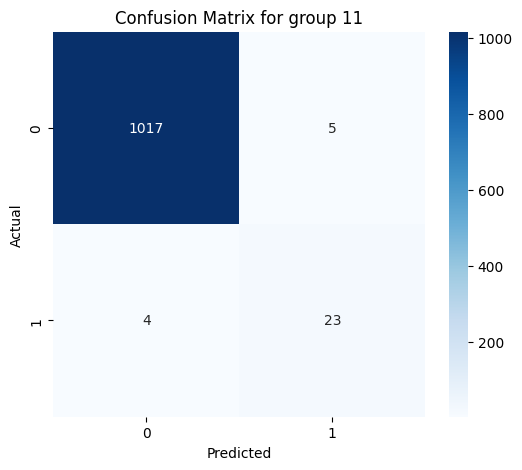

Group 11: SHAP values shape is (1049, 778) (1049 samples, 778 features)


In [154]:
# Flags for options
Trainall = False         # Set to False to use a train/test split (recommended for evaluation)
PipelineObject = True    # Whether to use the pipeline
use_shap = True          # Whether to compute SHAP values

# Dictionaries to store SHAP results
shap_values_dict = {}
shap_explainer_dict = {}

# Lists to store predictions and true values for later plotting
predictions = []
true_values = []

# Loop over each group/contingency in your dataset (adjust based on your data structure)
for contg in datapd3['CONTG'].unique():
    # Assuming X and Y are DataFrames indexed appropriately so that X.loc[contg] works.
    print(f'Features shape for group {contg}: {X.loc[contg].shape}')
    print(f'Labels shape for group {contg}: {Y.loc[contg].shape}')
    
    # Split the data
    if Trainall:
        X_train, Y_train = X.loc[contg], Y.loc[contg]
        # When training on all data, for SHAP we use training data as "test"
        X_test, Y_test = X_train, Y_train
    else:
        X_train, X_test, Y_train, Y_test = train_test_split(
            X.loc[contg], Y.loc[contg],
            test_size=0.2,
            random_state=42,
            stratify=Y.loc[contg]   # Stratified splitting to preserve class balance
        )
        print(f'Training features shape: {X_train.shape}')
        print(f'Training labels shape: {Y_train.shape}')
        print(f'Testing features shape: {X_test.shape}')
        print(f'Testing labels shape: {Y_test.shape}')
    
    # Preprocessing: list all feature names (assumed numeric)
    numerical_features = list(X_train.columns)
    # For simplicity, we only impute missing values. You can add StandardScaler() if needed.
    num_mapper = [([n], [SimpleImputer()]) for n in numerical_features]
    mapper = DataFrameMapper(num_mapper, df_out=True)
    
    # Compute the imbalance ratio in the training set.
    # Assuming the labels are binary (0 and 1)
    counter = Counter(Y_train.values.ravel())
    if counter.get(1, 0) > 0:
        scale_pos_weight = counter[0] / counter[1]
    else:
        scale_pos_weight = 1  # In case there are no positives, avoid division by zero.
    print(f'For group {contg}, scale_pos_weight is set to: {scale_pos_weight:.2f}')
    
    # Initialize the XGBClassifier with the computed scale_pos_weight
    model = xgb.XGBClassifier(
        objective="binary:logistic",
        n_estimators=100,
        random_state=42,
        scale_pos_weight=scale_pos_weight
    )
    
    # Create the pipeline with preprocessing and the classifier
    pipeline = Pipeline([
        ('preprocess', mapper),
        ('clf', model)
    ])
    
    print(f'Total samples for training in group {contg}: {X_train.shape[0]}')
    
    # Fit the model using the pipeline or direct model fit
    if PipelineObject:
        print('=== Using pipeline for training ===')
        pipeline.fit(X_train, Y_train)
        # Use the appropriate set for predictions
        y_pred = pipeline.predict(X_train if Trainall else X_test)
        Y_true = Y_train if Trainall else Y_test
    else:
        model.fit(X_train, Y_train)
        y_pred = model.predict(X_train if Trainall else X_test)
        Y_true = Y_train if Trainall else Y_test
    
    # Evaluation metrics
    accuracy = accuracy_score(Y_true, y_pred)
    balanced_acc = balanced_accuracy_score(Y_true, y_pred)
    f1 = f1_score(Y_true, y_pred, average='weighted')  # Use 'weighted' to account for class imbalance
    
    print(f'Accuracy: {accuracy:.4f}')
    print(f'Balanced Accuracy: {balanced_acc:.4f}')
    print(f'F1 Score: {f1:.4f}')
    print('\nClassification Report:')
    print(classification_report(Y_true, y_pred))
    
    # Plot confusion matrix
    conf_matrix = confusion_matrix(Y_true, y_pred)
    plt.figure(figsize=(6, 5))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
                xticklabels=model.classes_, yticklabels=model.classes_)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(f'Confusion Matrix for group {contg}')
    plt.show()
    
    # Save predictions and true values for further analysis if needed
    predictions.append(y_pred)
    true_values.append(Y_true)
    
    # SHAP Explainability
    if use_shap:
        # When training on all data, we use the training set for SHAP evaluation
        if Trainall:
            X_shap = X_train
        else:
            X_shap = X_test
        
        if PipelineObject:
            # Use the classifier from the pipeline (the fitted xgb model)
            explainer = shap.Explainer(pipeline['clf'], X_train)
            shap_values = explainer(X_shap)
            shap_vals_shape = np.shape(shap_values.values)
            print(f'Group {contg}: SHAP values shape is {shap_vals_shape} '
                  f'({shap_vals_shape[0]} samples, {shap_vals_shape[1]} features)')
        else:
            # Use the standalone model with TreeExplainer
            explainer = shap.TreeExplainer(model)
            shap_values = explainer.shap_values(X_shap)
            shap_vals_shape = np.shape(shap_values)
            print(f'Group {contg}: SHAP values shape is {shap_vals_shape} '
                  f'({shap_vals_shape[0]} samples, {shap_vals_shape[1]} features)')
        
        # Save the SHAP values in the dictionaries using the group identifier
        shap_explainer_dict[f'Contingency_{contg}'] = explainer
        # When using the pipeline, shap_values is a container with a .values attribute
        try:
            shap_values_dict[f'Contingency_{contg}'] = shap_values.values
        except AttributeError:
            # If using TreeExplainer without a pipeline
            shap_values_dict[f'Contingency_{contg}'] = shap_values

In [155]:
shap_explainer_dict.keys()

dict_keys(['Contingency_11'])

SHAP values shape: (1049, 778)


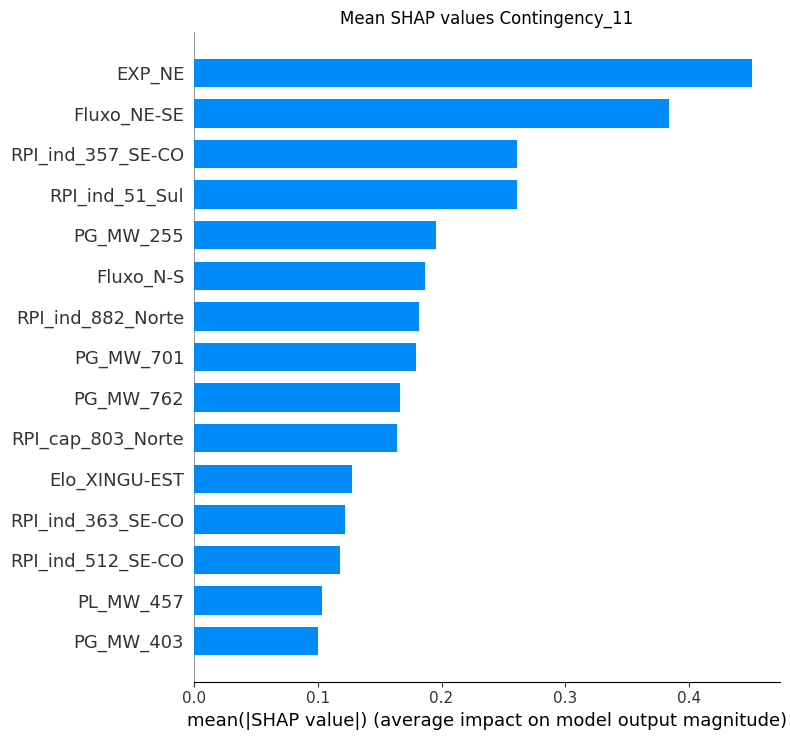

In [156]:
# Retrieve the explainer from the dictionary

for keysy in shap_explainer_dict.keys():
    explainer = shap_explainer_dict[keysy]

    # Compute SHAP values for X_test (assuming you want the 2D array)
    shap_values = explainer.shap_values(X_test)
    print("SHAP values shape:", shap_values.shape)

    # For a binary classification model, shap_values is often a 2D array (n_samples, n_features)
    # If it is instead a list (one array per class), you might need to select one. For example, for the positive class:
    # shap_values = shap_values[1]

    # Since the SHAP values are 2D, no need to slice along a third dimension.
    plt.figure()
    plt.title('Mean SHAP values ' + keysy)
    shap.summary_plot(shap_values, X_test, plot_type="bar", max_display=15, feature_names=X_test.columns)
    plt.show()


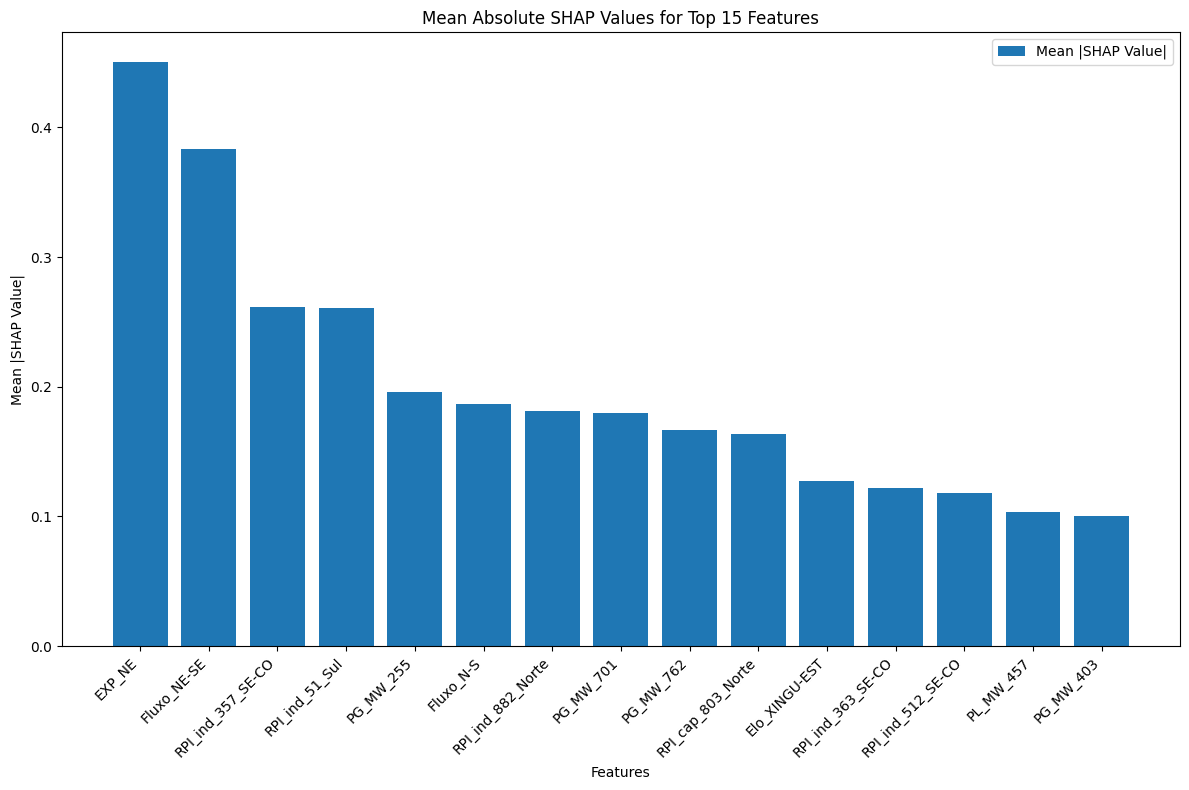

In [157]:
# For 2D shap_values (n_samples, n_features)
mean_shap_values = np.mean(np.abs(shap_values), axis=0)  # shape: (n_features,)

# Sort features by mean SHAP value in descending order
sorted_indices = np.argsort(mean_shap_values)[::-1]
n = 15
top_features = X_test.columns[sorted_indices][:n]
top_shap_values = mean_shap_values[sorted_indices][:n]

plt.figure(figsize=(12, 8))
plt.bar(top_features, top_shap_values, label="Mean |SHAP Value|")
plt.title(f'Mean Absolute SHAP Values for Top {n} Features')
plt.xlabel('Features')
plt.ylabel('Mean |SHAP Value|')
plt.xticks(rotation=45, ha='right')
plt.legend()
plt.tight_layout()
plt.show()

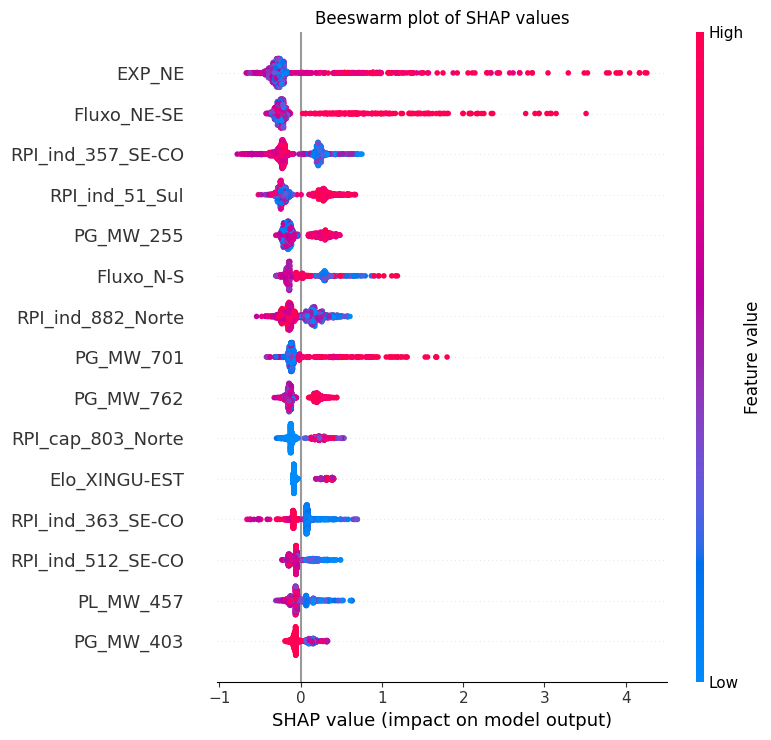

In [158]:
plt.figure()
plt.title('Beeswarm plot of SHAP values')
shap.summary_plot(shap_values, X_test, max_display=15)
plt.show()

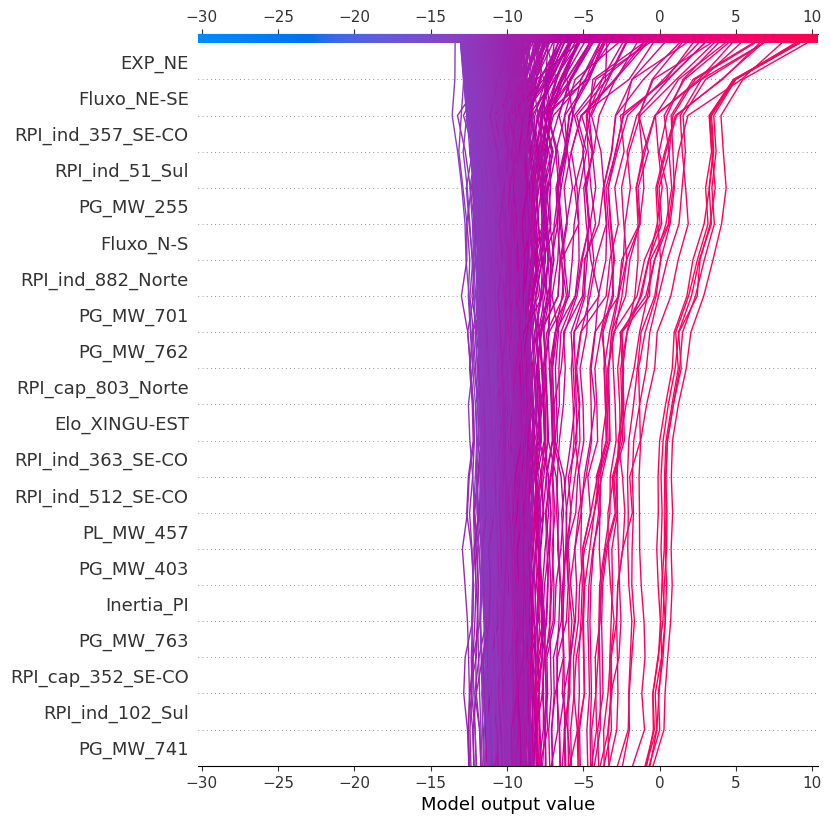

In [159]:
# Decision plot for a set of samples (e.g., the entire test set)
shap.decision_plot(explainer.expected_value, shap_values, X_test)

In [160]:
listadias = datapd3[datapd3['Label']==1].index.get_level_values('key').unique().to_list()
listadias

['D_10_H_09-30',
 'D_10_H_10-00',
 'D_10_H_10-30',
 'D_10_H_11-00',
 'D_10_H_11-30',
 'D_10_H_12-00',
 'D_10_H_12-30',
 'D_10_H_13-00',
 'D_10_H_13-30',
 'D_10_H_14-00',
 'D_10_H_14-30',
 'D_11_H_07-00',
 'D_11_H_07-30',
 'D_11_H_08-00',
 'D_11_H_08-30',
 'D_11_H_10-00',
 'D_11_H_10-30',
 'D_11_H_11-00',
 'D_11_H_11-30',
 'D_11_H_12-00',
 'D_11_H_12-30',
 'D_11_H_13-00',
 'D_11_H_13-30',
 'D_12_H_07-30',
 'D_12_H_08-00',
 'D_12_H_08-30',
 'D_13_H_08-30',
 'D_13_H_09-00',
 'D_14_H_07-00',
 'D_14_H_07-30',
 'D_14_H_08-00',
 'D_14_H_08-30',
 'D_14_H_11-00',
 'D_14_H_11-30',
 'D_14_H_12-30',
 'D_15_H_08-00',
 'D_15_H_08-30',
 'D_15_H_09-00',
 'D_15_H_09-30',
 'D_15_H_10-00',
 'D_15_H_10-30',
 'D_15_H_11-00',
 'D_15_H_11-30',
 'D_15_H_12-00',
 'D_15_H_12-30',
 'D_15_H_13-30',
 'D_17_H_07-00',
 'D_17_H_07-30',
 'D_17_H_08-00',
 'D_17_H_08-30',
 'D_17_H_09-00',
 'D_17_H_09-30',
 'D_17_H_10-00',
 'D_17_H_10-30',
 'D_17_H_11-00',
 'D_17_H_11-30',
 'D_18_H_07-00',
 'D_18_H_07-30',
 'D_18_H_08-00

In [161]:
listadias.index('D_1_H_13-30')

75

In [162]:
datarst_2['V1A1F2']['D_1_H_13-30'][51]

{'ETIM': '27.238',
 'CODE': '4',
 'STAB': ['2.0000', '8798', '0', '0', '1', 'Voltage']}

In [163]:
Y_test.reset_index()[Y_test.reset_index()['Label']==1]

,CONTG,Label
5,11,1
14,11,1
32,11,1
35,11,1
113,11,1
137,11,1
169,11,1
183,11,1
246,11,1
312,11,1


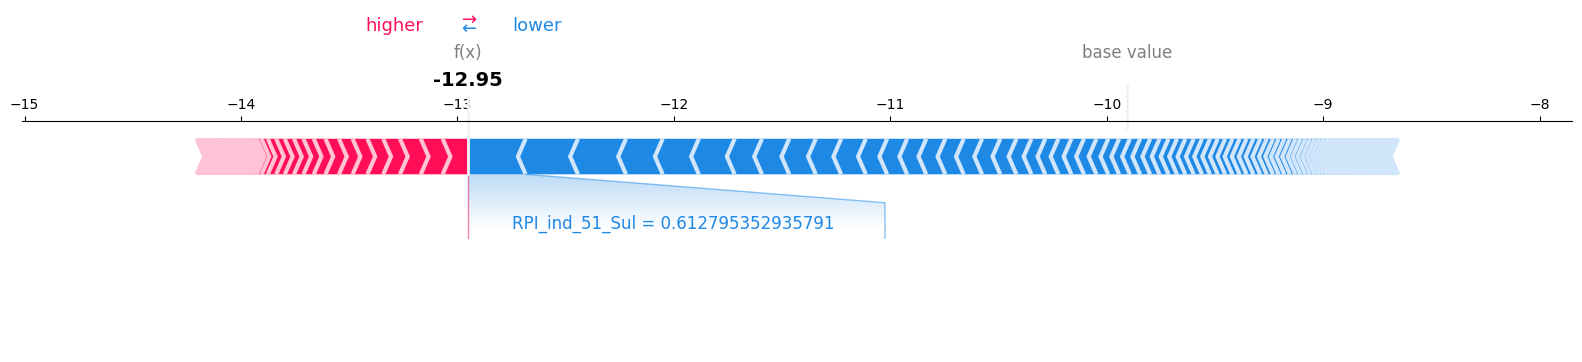

In [164]:
# For an individual sample, e.g., the first sample in X_test
sample_index = 125
shap.initjs()
# Generate the force plot
force_plot = shap.force_plot(
    explainer.expected_value,  # The base value (e.g., average model output)
    shap_values[sample_index, :],  # SHAP values for the selected sample
    X_test.iloc[sample_index, :],  # Corresponding feature values
     matplotlib=True  # Optional: use matplotlib instead of the interactive JS plot
)

# If you're in a Jupyter environment, the plot may automatically display.


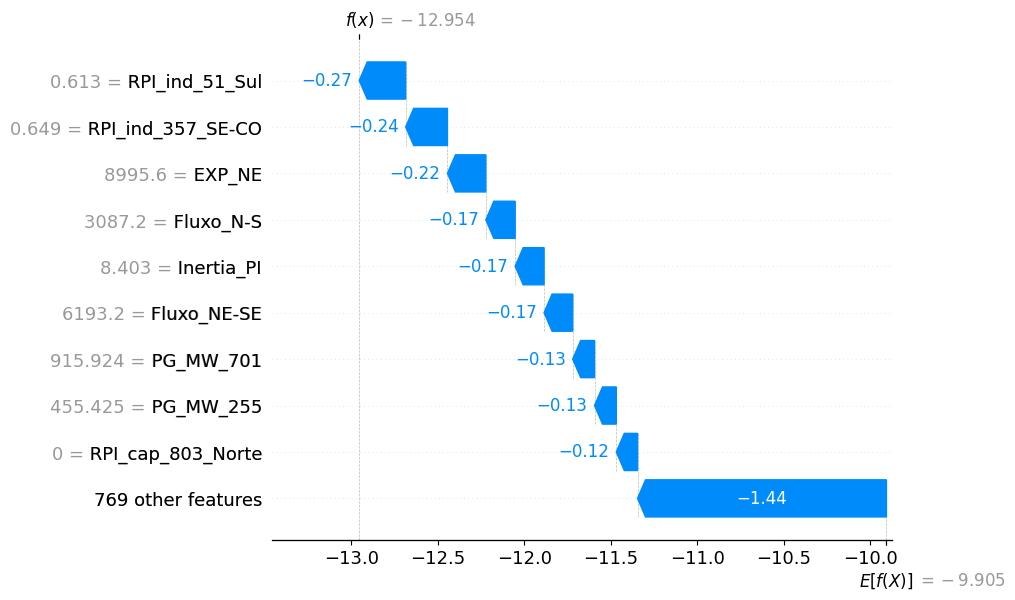

In [165]:
# Create a waterfall plot for a single sample:
shap.waterfall_plot(
    shap.Explanation(
        values=shap_values[sample_index, :],
        base_values=explainer.expected_value,
        data=X_test.iloc[sample_index, :],
        feature_names=X_test.columns.tolist()
    )
)


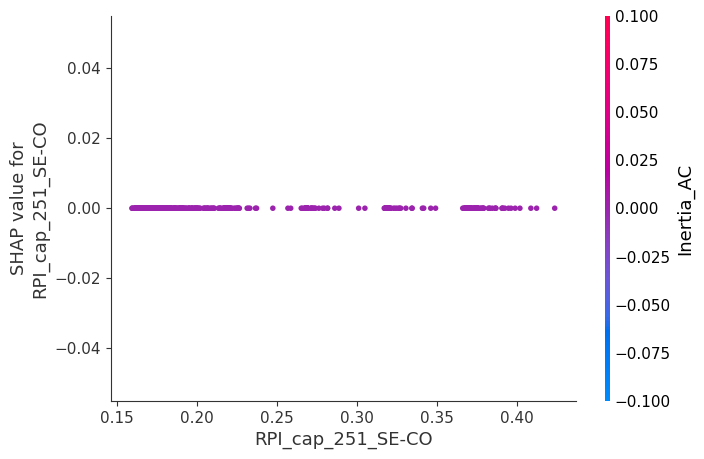

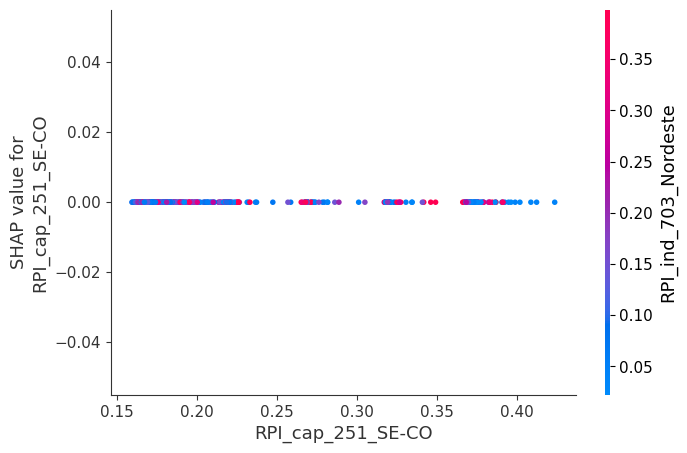

In [166]:
# Replace 'feature_name' with the name of the feature you want to analyze.
feature_name = "RPI_cap_251_SE-CO"

# Generate a dependence plot
shap.dependence_plot(feature_name, shap_values, X_test)
# Example with an interaction index
shap.dependence_plot(feature_name, shap_values, X_test, interaction_index="RPI_ind_703_Nordeste")

In [167]:
# Activar mayor generacion en la area 251 SECO para comprobar si consigo solucionar el problema de la contingencia 49. Colocar en el Organon un compensador sincrono para observar como interfiere en la contingencia 49.